<img src = "https://raw.githubusercontent.com/barcelonagse-datascience/academic_files/master/images/BSE_DSC_HEADER.jpg">

# Decision trees and Ensembles

## Programming project: length of stay

In this project, you have to predict the length of stay (in days) of a patient that is entering an ICU (Intensive Care Unit) using decision tree and ensemble models.

The dataset comes from MIMIC project (https://mimic.physionet.org/). MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

Each row of *mimic_train.csv* correponds to one ICU stay (*hadm_id*+*icustay_id*) of one patient (*subject_id*). Column *LOS* is the length of stay of this patient, equal to discharge time minus admit time.
The remaining columns correspond to vitals of each patient (when entering the ICU), plus some general characteristics (age, gender, etc.), and their explanation can be found at *mimic_patient_metadata.csv*.
Please don't use any feature that you infer you don't know the first day of a patient in an ICU.

Note that the main cause/disease of patient contidition is embedded as a code at *ICD9_diagnosis* column. The meaning of this code can be found at *MIMIC_metadata_diagnose.csv*. **But** this is only the main one; a patient can have co-occurrent diseases (comorbidities). These secondary codes can be found at *extra_data/MIMIC_diagnoses.csv*.

Don't use features that you don't know the first day a patient enters the ICU, such as *HOSPITAL_EXPIRE_FLAG*

As performance metric, please use *RMSE* (root mean squared error).

Main tasks are:
+ Using *mimic_train.csv* file build a predictive model for *LOS* .
+ For this analysis there is an extra test dataset, *mimic_test_los.csv*. Apply your final model to this extra dataset and generate predictions following the same format as *mimic_kaggle_los_sample_submission.csv*. Once ready, you can submit to our Kaggle competition and iterate to improve the accuracy.

As a *bonus*, try different decision trees algorithms, even combine with other prediction models.  Try to assess which features are more important, and if possible the confidence interval of predictions.

You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. 
2. Manage missing data.
2. Manage categorical features. E.g. create *dummy variables* for relevant categorical features, or build an ad hoc distance function.
3. Build a prediction model
5. Assess expected accuracy  of previous models using *cross-validation*. 
6. Predict on the test file, following same preparation steps (missing data, dummies, etc). Remember that you should be able to yield a prediction for all the rows of the test dataset. Submit to Kaggle to check performance.

Data
+ Code runs        5% - That your code runs and you are using sklearn (and beyond) correctly
+ Data preparation        5% - That you know how to preprocess the data before applying the models

Decision trees
+ Decision trees method(s) have been used        10% - That you have fit at least one decision tree method and you understand which arguments you can consider for tuning
+ Hyperparameter optimization        10% - That you understand how to use a GridSearch to tune/regularise your Decision Tree parameters

Ensembles 
+ Ensemble method(s) have been used    10% - That you have fit at least one ensemble model and you understand which arguments you can consider tuning
+ Complexity of ensemble used   10% - How advanced was your ensemble? Did it include more than tree models? How did the ensemble learn to combine the models?

Neural Networks
+ Neural Networks method(s) have been used    10% - That you have fit at least one Neural Network model and you understand how to diagnose convergence of your model training
+ Complexity of Neural Network   10% - How advanced was your Neural Network? What types of regularisation did you consider?

Other
+ Length of stay is predicted for each test patient   5% - That you submitted out-of-sample predictions to kaggle and received a score

+ Accuracy of you best predictions   10% - The Kaggle score for your best model
+ Attempts made to interpret predictions   5% - That you attempted to interpret your ensemble or Neural Network predictions using LIME or SHAP
+ Neat and understandable code, with some titles and comments        5% - Comments showing good understanding of why you do what you do and how the output is interpreted
+ Improved methods from what we discussed in class (properly explained/justified)        5% - Methods used beyond those shown in class, this could involve further preprocessing steps than seen in class, and extensions to the models.


# 1. Libraries

In [1]:
#!pip install mlens

In [2]:
# imports
# Set path
import os
os.chdir('/Users/bakwe/Desktop/Masters BSE/Deep learning/Decision tree')
#import auxiliar functions
import sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(os.path.dirname(currentdir))
sys.path.insert(1, parentdir)
# import Jack's custom functions
from utils.helper_functions import *


In [79]:

%matplotlib inline
import matplotlib.pylab as plt 
from dateutil.relativedelta import relativedelta

import pandas as pd
import numpy as np
from numpy import sqrt
import seaborn as sns
import sklearn
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR 
from sklearn import preprocessing
from sklearn.metrics import  r2_score, mean_squared_error
from sklearn.linear_model import Lasso, Ridge
from sklearn.experimental import enable_iterative_imputer
import category_encoders as ce
from sklearn.model_selection import GridSearchCV


from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, ParameterGrid

import mlens
from mlens.visualization import corrmat
from mlens.ensemble import SuperLearner, BlendEnsemble, Subsemble, SequentialEnsemble

from category_encoders import  WOEEncoder

import datetime as dt
from datetime import timedelta
import missingno as msno # Our hero ^_^

## Modules for scalers, imputers and encoders 
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.decomposition import PCA

## Modules to run our models
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


## Modules for constructing Pipelines
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from pipelinehelper import PipelineHelper
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor


## Modules to check accuracy of our models
#from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, roc_auc_score, roc_curve
#from sklearn import datasets, metrics, model_selection
from sklearn.model_selection import cross_val_predict

from datetime import datetime, timedelta
import time


In [4]:
# Re-usable plotting function
def plot_los_groupby(variable, size=(7,4)):
    ''' 
    Plot Median LOS by df categorical series name 
    '''
    results = df[[variable, 'LOS']].groupby(variable).median().reset_index()
    values = list(results['LOS'].values)
    labels = list(results[variable].values)

    fig, ax = plt.subplots(figsize=size)
    ind = range(len(results))
    ax.barh(ind, values, align='center', height=0.6, color = '#55a868', alpha=0.8)
    ax.set_yticks(ind)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Median Length of Stay (days)')
    ax.tick_params(left=False, top=False, right=False) 
    ax.set_title('Comparison of {} labels'.format(variable))
    
    plt.tight_layout()
    plt.show();

# Re-usable boxplot function
def boxplot_los_groupby(variable, los_range=(-1, 30), size=(8,4)):
    ''' 
    Boxplot of LOS by df categorical series name 
    '''
    results = df[[variable, 'LOS']].groupby(variable).median().reset_index()

    categories = results[variable].values.tolist()

    hist_data = []
    for cat in categories:
        hist_data.append(df['LOS'].loc[df[variable]==cat].values)

    fig, ax = plt.subplots(figsize=size)
    ax.boxplot(hist_data, 0, '', vert=False)
    ax.set_xlim(los_range)
    ax.set_yticklabels(categories)
    ax.set_xlabel('Length of Stay (days)')
    ax.tick_params(left=False, right=False) 
    ax.set_title('Comparison of {} categories'.format(variable))
    plt.tight_layout()
    plt.show();

# 2. Importing our dataset

In [5]:
# Training dataset.
df=pd.read_csv('mimic_train.csv')

#Test dataset
df_test=pd.read_csv('mimic_test_los.csv')

Quick review of our data

In [6]:
df.describe()

,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,Diff,LOS
count,20885.000000,20885.000000,20885.000000,20885.000000,18698.000000,18698.000000,18698.000000,18677.000000,18677.000000,18677.000000,...,18388.000000,18388.000000,18682.000000,18682.000000,18682.000000,20632.000000,20632.000000,20632.000000,20885.000000,20885.000000
mean,0.112282,58950.496098,150082.402298,250202.495523,69.705904,105.239801,85.180250,91.110564,150.725920,119.145423,...,37.428781,36.751717,91.007494,99.555883,96.866685,106.781975,182.129604,138.856428,-51617.069830,3.701046
std,0.315720,25299.439535,28898.479845,28909.806302,14.869840,20.922613,15.318208,17.532534,23.833793,16.701503,...,0.799897,0.603476,7.399390,1.159792,2.333108,35.178811,92.665603,44.933145,10686.395846,5.175721
min,0.000000,23.000000,100001.000000,200001.000000,2.000000,39.000000,34.714286,5.000000,46.000000,46.000000,...,30.800000,30.666667,1.000000,57.000000,47.666667,2.000000,42.000000,42.000000,-72740.274440,0.056600
25%,0.000000,41132.000000,125157.000000,225153.000000,60.000000,90.000000,74.272727,81.000000,134.000000,107.100000,...,36.944444,36.388889,90.000000,100.000000,95.812500,86.000000,126.000000,110.750000,-60864.454110,1.165400
50%,0.000000,60441.000000,150152.000000,250452.000000,69.000000,103.000000,84.131183,90.000000,148.000000,116.901961,...,37.333333,36.731481,92.000000,100.000000,97.142857,102.000000,161.000000,128.666667,-51561.703460,2.020800
75%,0.000000,80286.000000,175017.000000,275303.000000,79.000000,118.000000,95.185588,101.000000,164.000000,129.465116,...,37.888889,37.092593,94.000000,100.000000,98.346154,121.000000,206.000000,154.578571,-42327.560030,3.915800
max,1.000000,99999.000000,199999.000000,299998.000000,141.000000,280.000000,163.875000,181.000000,323.000000,202.172414,...,42.000000,40.238333,100.000000,100.000000,100.000000,563.000000,2440.000000,771.900000,-32157.494580,101.739000


In [7]:
df.columns

Index(['HOSPITAL_EXPIRE_FLAG', 'subject_id', 'hadm_id', 'icustay_id',
       'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'GENDER', 'DOB', 'ADMITTIME', 'Diff', 'ADMISSION_TYPE',
       'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS',
       'ICD9_diagnosis', 'FIRST_CAREUNIT', 'LOS'],
      dtype='object')

In [8]:
df_test.describe()

,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,...,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,Diff
count,5221.000000,5221.000000,5221.000000,4676.000000,4676.000000,4676.000000,4670.000000,4670.000000,4670.000000,4669.000000,...,4583.000000,4583.000000,4583.000000,4670.000000,4670.000000,4670.000000,5163.000000,5163.000000,5163.000000,5221.000000
mean,58870.629573,150248.186746,249925.293239,69.942686,105.279940,85.221128,90.862392,150.547966,118.763143,44.142643,...,36.041879,37.441470,36.755418,90.828480,99.553319,96.857538,107.823494,376.578346,163.521697,-51606.334303
std,25320.956194,28679.538155,28763.030681,15.013524,21.247956,15.484126,17.529140,23.575450,16.490767,11.695481,...,0.762967,0.797153,0.595941,7.660437,1.516541,2.406957,34.312518,13915.510710,1739.829727,10666.881712
min,107.000000,100033.000000,200011.000000,1.000000,42.000000,36.000000,10.000000,62.000000,51.750000,6.000000,...,22.777778,32.555556,32.222222,1.000000,42.000000,42.000000,15.000000,32.000000,32.000000,-72639.620300
25%,41055.000000,125246.000000,225118.000000,60.000000,90.000000,74.035131,81.000000,134.000000,106.752976,37.000000,...,35.666667,36.944444,36.409722,90.000000,100.000000,95.840227,87.000000,126.000000,111.500000,-60840.730090
50%,60057.000000,150492.000000,249759.000000,69.000000,104.000000,83.957428,90.000000,148.000000,116.807407,44.000000,...,36.111111,37.333333,36.738095,92.000000,100.000000,97.134848,102.000000,160.000000,129.000000,-51612.812060
75%,80313.000000,174983.000000,274576.000000,79.000000,118.000000,95.477143,101.000000,164.000000,128.862844,51.000000,...,36.500000,37.888889,37.091705,94.000000,100.000000,98.333333,122.000000,205.000000,155.060976,-42552.065720
max,99992.000000,199967.000000,299979.000000,143.000000,220.000000,155.571429,162.000000,290.000000,195.250000,97.000000,...,39.388889,41.111111,39.527778,100.000000,100.000000,100.000000,374.000000,999999.000000,125110.125000,-32176.628480


In [9]:
df_test.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'HeartRate_Min', 'HeartRate_Max',
       'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min',
       'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
       'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
       'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
       'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'GENDER', 'DOB',
       'ADMITTIME', 'Diff', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'ICD9_diagnosis',
       'FIRST_CAREUNIT'],
      dtype='object')

In [10]:
print('train datset:', df.shape);
print('test dataset:', df_test.shape)

train datset: (20885, 41)
test dataset: (5221, 39)


In [11]:
#Lets see how many columns are missing in our test data
cols_df1_not_df2 = set(df.columns) - set(df_test.columns)
print('Missing column in test data:', cols_df1_not_df2)

Missing column in test data: {'HOSPITAL_EXPIRE_FLAG', 'LOS'}


In [12]:
df_train_copy = df.copy()
df_test_copy = df_test.copy()

In [13]:
print(df_train_copy.isna().sum()); print(df_test_copy.isna().sum())

HOSPITAL_EXPIRE_FLAG       0
subject_id                 0
hadm_id                    0
icustay_id                 0
HeartRate_Min           2187
HeartRate_Max           2187
HeartRate_Mean          2187
SysBP_Min               2208
SysBP_Max               2208
SysBP_Mean              2208
DiasBP_Min              2209
DiasBP_Max              2209
DiasBP_Mean             2209
MeanBP_Min              2186
MeanBP_Max              2186
MeanBP_Mean             2186
RespRate_Min            2189
RespRate_Max            2189
RespRate_Mean           2189
TempC_Min               2497
TempC_Max               2497
TempC_Mean              2497
SpO2_Min                2203
SpO2_Max                2203
SpO2_Mean               2203
Glucose_Min              253
Glucose_Max              253
Glucose_Mean             253
GENDER                     0
DOB                        0
ADMITTIME                  0
Diff                       0
ADMISSION_TYPE             0
INSURANCE                  0
RELIGION      

We can plot the 'LOS' column distribution graph from our train data (df) to see our data more clearly

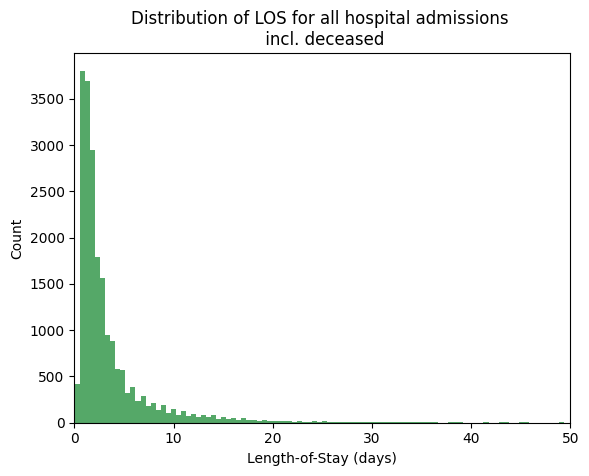

In [14]:
# Plot LOS Distribution (deceased here means when HOSPITAL_EXPIRE_FLAG = 1)
plt.hist(df_train_copy['LOS'], bins=200, color = '#55a868')
plt.xlim(0, 50)
plt.title('Distribution of LOS for all hospital admissions \n incl. deceased')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show();

Patients who died at the hospital will later be dropped from the Dataset as they would bias the LOS since they never were discharged 'alive' from the hospital. In other words, LOS would be shorter for this group.</br> <bold>!NB: This is an idea in progress. </bold>

In [15]:
#Just looking at our deceased patients
df_train_copy.HOSPITAL_EXPIRE_FLAG.value_counts()

0    18540
1     2345
Name: HOSPITAL_EXPIRE_FLAG, dtype: int64

In [16]:
#Here we see the amount that passed away in the hospital. The amount of total patients reduced, meaning there must have been patients who visited multiple times. 
print("{} of {} patients died in the hospital".format(df_train_copy['HOSPITAL_EXPIRE_FLAG'].sum(), 
                                                     df_train_copy['subject_id'].nunique()))

2345 of 16317 patients died in the hospital


In [17]:
# Look at statistics less admissions resulting in death
df_train_copy['LOS'].loc[df_train_copy['HOSPITAL_EXPIRE_FLAG'] == 0].describe()

count    18540.000000
mean         3.463283
std          4.763462
min          0.056600
25%          1.159850
50%          1.975400
75%          3.661050
max        101.739000
Name: LOS, dtype: float64

In [18]:
# Hospital LOS metrics for later comparison
actual_mean_los = df_train_copy['LOS'].loc[df_train_copy['HOSPITAL_EXPIRE_FLAG'] == 0].mean() 
actual_median_los = df_train_copy['LOS'].loc[df_train_copy['HOSPITAL_EXPIRE_FLAG'] == 0].median() 

print(actual_mean_los)
print(actual_median_los)

3.4632831715210353
1.9754


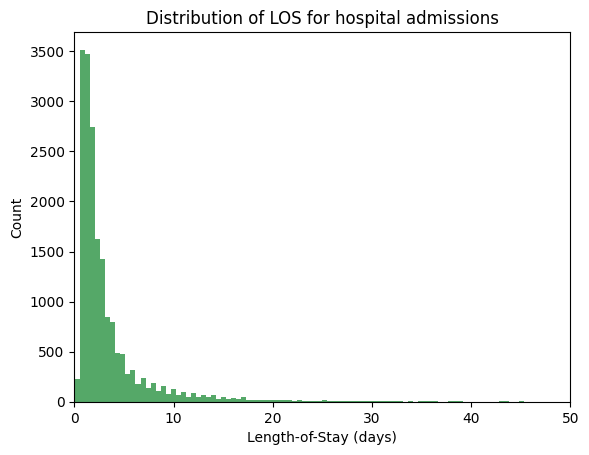

In [19]:
plt.hist(df_train_copy['LOS'].loc[df_train_copy['HOSPITAL_EXPIRE_FLAG'] == 0], bins=200, color = '#55a868')
plt.xlim(0, 50)
plt.title('Distribution of LOS for hospital admissions')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show();

Next, let's study more about these patients

In [20]:
icu_reentries = df_train_copy.groupby('subject_id').count()
df_train_copy ['icu_reentries'] = df_train_copy['subject_id'].replace(to_replace=icu_reentries.index, value=icu_reentries.values)
max_reentries = df_train_copy ['icu_reentries'].max()
max_reentries

25

In [21]:
df_test_copy['icu_reentries'] = df_test_copy['subject_id'].replace(to_replace=icu_reentries.index, value=icu_reentries.values+1)
df_test_copy['icu_reentries'] = np.where(df_test_copy['icu_reentries'] >max_reentries, 1, df_test_copy['icu_reentries'])

In [22]:
# Just checking the shape
print(df_train_copy.shape);
print(df_test_copy.shape)

(20885, 42)
(5221, 40)


Next we will get more features using what we have

In [23]:
for I in [df_train_copy, df_test_copy]:
    I['Diff'] = I.apply(lambda x: timedelta(days=-x.Diff),axis=1)
    I['ADMITTIME'] = I.apply(lambda x: dt.datetime.strptime(x.ADMITTIME,'%Y-%m-%d %H:%M:%S'),axis=1)
    I['ADMITTIME'] = I.apply(lambda x: (x.ADMITTIME.to_pydatetime() - x.Diff),axis=1)
    I['DOB'] = I.apply(lambda x: dt.datetime.strptime(x.DOB,'%Y-%m-%d %H:%M:%S'),axis=1)
    I['DOB'] = I.apply(lambda x: (x.DOB.to_pydatetime() - x.Diff),axis=1)
    I['age'] = I.apply(lambda x: relativedelta(x.ADMITTIME, x.DOB).years, axis=1)
    #new addition 25.03
    I['age'] = np.where(I['age'] > 100 , random.randint(89, 99), I['age'])


*Handle Outlier: Age.* Notice there is a relatively many occurances where outliers exist. In the `mimic-code` [github](https://github.com/MIT-LCP/mimic-code/issues/637), it is stated "Dates of birth for patients aged over 89 were shifted to obscure their true age and comply with HIPAA regulations: these patients appear in the database with ages of over 300 years". In these cases, we can only know they are older than 89, but no more information of the exact age like 92, 93. I will handle this by generating and assigning a random number from `89` to `99` for these occurances.

In [24]:
df_train_copy['age'] = df_train_copy.age.where(df_train_copy['age']<89, 90)
df_test_copy['age'] = df_test_copy.age.where(df_test_copy['age']<89, 90)

In [25]:
#I just have to keep track that the columns are in check
print(df_train_copy.shape);
print(df_test_copy.shape)

(20885, 43)
(5221, 41)


Comorbidities review

In [26]:
comorbidities = pd.read_csv("MIMIC_diagnoses.csv")
comorbidities.columns = [x.lower() for x in comorbidities.columns]
comorbidities

,subject_id,hadm_id,seq_num,icd9_code
0,256,108811,1.0,53240
1,256,108811,2.0,41071
2,256,108811,3.0,53560
3,256,108811,4.0,40390
4,256,108811,5.0,5859
...,...,...,...,...
651042,65535,178280,5.0,5119
651043,65535,178280,6.0,5990
651044,65535,178280,7.0,0414
651045,65535,178280,8.0,25000


In [27]:
# get the number of diagnosis
number_comorbidities_patient = comorbidities[['hadm_id', 'seq_num']].groupby(['hadm_id'], sort = False).max()

# merge that data with original train and test datasets
df_train_copy = df_train_copy.merge(number_comorbidities_patient, on = ['hadm_id'], how = 'left')
df_test_copy = df_test_copy.merge(number_comorbidities_patient, on = ['hadm_id'], how = 'left')

*ICD-9 Codes.* ICD-9 codes are grouped by the first 3 digits (see [Wikipedia](https://en.wikipedia.org/wiki/List_of_ICD-9_codes)).  For example, icd9_code `53240` belongs to subgroup `520–579: diseases of the digestive system`, and code `25000` belongs to subgroup `240–279: endocrine, nutritional and metabolic diseases, and immunity disorders`, and so on. Since the original dataset has almost 7000 unique `icd9_code`, grouping them by these subgroups can contain them more effectively. Here, I parse the first 3 digits of the `ICD9_diagnosis` and create a `icd9_subgroup` column.

Note: Some codes begin with `E` or `V` instead of digits, as well as some with leading zeros. For now, I set them as some arbitary value to handle later on.

In [28]:
# Filter out E and V codes since processing will be done on the numeric first 3 values
comorbidities['icd9_subgroup'] = comorbidities['icd9_code'][~comorbidities['icd9_code'].str.contains("[a-zA-Z]").fillna(False)]
comorbidities['icd9_subgroup'].fillna(value='-99999', inplace=True)

# slice strings
comorbidities['icd9_subgroup'] = comorbidities['icd9_subgroup'].str.slice(start=0, stop=3, step=1)
comorbidities['icd9_subgroup'] = comorbidities['icd9_subgroup'].astype(int)

comorbidities.head(15)

,subject_id,hadm_id,seq_num,icd9_code,icd9_subgroup
0,256,108811,1.0,53240,532
1,256,108811,2.0,41071,410
2,256,108811,3.0,53560,535
3,256,108811,4.0,40390,403
4,256,108811,5.0,5859,585
5,256,108811,6.0,04186,41
6,256,108811,7.0,41401,414
7,256,108811,8.0,2724,272
8,256,108811,9.0,496,496
9,256,108811,10.0,42731,427


In [29]:
# ICD-9 top-level ranges
icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390), 
               (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000),(1000, 2000), (-99999,-1)]

# grouping names
diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
             4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
             8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin', 
             12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'symptoms',
             16: 'injury', 17: 'misc', 18: 'E and V'}

# re-code in terms of integer
for num, cat_range in enumerate(icd9_ranges):
    range_begin = cat_range[0]
    range_end = cat_range[1]
    comorbidities['icd9_subgroup'] = np.where(comorbidities['icd9_subgroup'].between(range_begin, range_end), num, comorbidities['icd9_subgroup'])

comorbidities.head(15)

,subject_id,hadm_id,seq_num,icd9_code,icd9_subgroup
0,256,108811,1.0,53240,8
1,256,108811,2.0,41071,6
2,256,108811,3.0,53560,8
3,256,108811,4.0,40390,6
4,256,108811,5.0,5859,9
5,256,108811,6.0,04186,0
6,256,108811,7.0,41401,6
7,256,108811,8.0,2724,2
8,256,108811,9.0,496,7
9,256,108811,10.0,42731,6


In [30]:
# merge subgroup data in main dataframe, match on 'seq_num' so we know which icd9_subgroup diagnosis the patient died from
df_train_copy = df_train_copy.merge(comorbidities[['hadm_id','seq_num','icd9_subgroup']], on = ['hadm_id','seq_num'], how = 'left')
df_test_copy = df_test_copy.merge(comorbidities[['hadm_id','seq_num','icd9_subgroup']], on = ['hadm_id','seq_num'], how = 'left')

Let's have a look at some categorical and numerical variables

Marital status

In [31]:
print('train:', df_train_copy['MARITAL_STATUS'].value_counts(dropna=False));
print('test:', df_test_copy['MARITAL_STATUS'].value_counts(dropna=False))

train: MARRIED              9664
SINGLE               5910
WIDOWED              2819
DIVORCED             1413
NaN                   722
SEPARATED             240
UNKNOWN (DEFAULT)     103
LIFE PARTNER           14
Name: MARITAL_STATUS, dtype: int64
test: MARRIED              2461
SINGLE               1438
WIDOWED               709
DIVORCED              353
NaN                   180
SEPARATED              51
UNKNOWN (DEFAULT)      28
LIFE PARTNER            1
Name: MARITAL_STATUS, dtype: int64


In [32]:
df_train_copy['MARITAL_STATUS'] = df_train_copy['MARITAL_STATUS'].fillna('UNKNOWN')
df_test_copy['MARITAL_STATUS'] = df_train_copy['MARITAL_STATUS'].fillna('UNKNOWN')

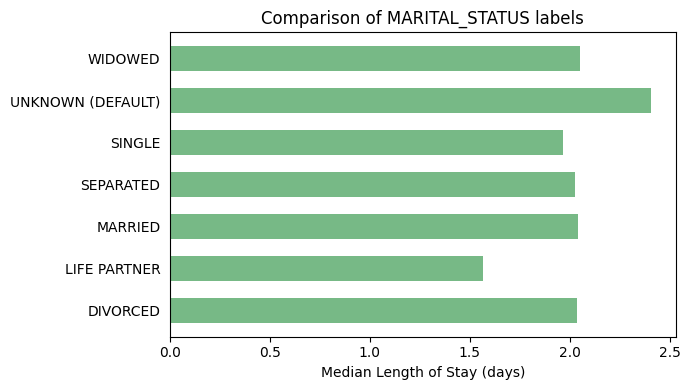

In [33]:
#Let's see some graphs!!
plot_los_groupby('MARITAL_STATUS')

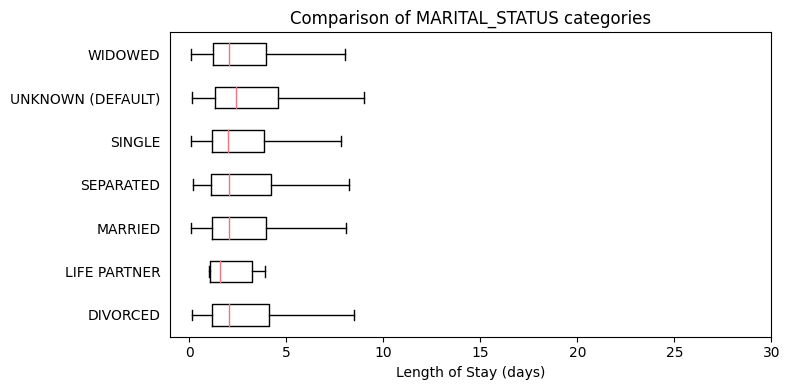

In [34]:
boxplot_los_groupby('MARITAL_STATUS')

The most people that stayed in the hospital didn't give their marital status

In [35]:
#splitting categorical and numerical features 

categorical_features = ["GENDER", "ADMISSION_TYPE", "INSURANCE", "FIRST_CAREUNIT", "MARITAL_STATUS", "RELIGION",
             "ETHNICITY", "ICD9_diagnosis", "DIAGNOSIS"]


# Categorical Data
df_train_cat = df_train_copy[categorical_features]
df_test_cat = df_test_copy[categorical_features]

# Set numerical data frame
df_num_train = df_train_copy.drop(categorical_features, axis=1)
df_num_test = df_test_copy.drop(categorical_features,axis = 1)

We have lots of categorical variables left that needs our attention. Some of these variables can be edditied to reduce the columns. </br>
- Religion: for example has a lot different unique variables, In a different model I divided it all into 3 groups (Religious, Unobtainable, and Not specified). It yielded a low score and so I won't be doing it here. 
- Ethnicity: has 41 unique variables. So, I decided to group them into Asian, Black, White, Hispanic or Latino, Other, etc. 

In [36]:
#So many different religion.
df_train_copy.RELIGION.value_counts()

CATHOLIC                  7655
NOT SPECIFIED             5398
PROTESTANT QUAKER         2753
JEWISH                    1840
UNOBTAINABLE              1515
OTHER                      702
EPISCOPALIAN               288
GREEK ORTHODOX             178
CHRISTIAN SCIENTIST        164
BUDDHIST                   109
MUSLIM                      74
UNITARIAN-UNIVERSALIST      54
JEHOVAH'S WITNESS           45
ROMANIAN EAST. ORTH         41
HINDU                       38
7TH DAY ADVENTIST           30
HEBREW                       1
Name: RELIGION, dtype: int64

In [37]:
df_train_cat.ETHNICITY.nunique()

41

In [38]:
#For ETNICITY
for I in [df_train_cat, df_test_cat]:
    I['ETHNICITY'] = I['ETHNICITY'].replace(['ASIAN', 'ASIAN - CHINESE', 'ASIAN - ASIAN INDIAN', 'ASIAN - VIETNAMESE', 'ASIAN - FILIPINO', 'ASIAN - CAMBODIAN',
                                                     'ASIAN - JAPANESE', 'ASIAN - THAI', 'ASIAN - OTHER', 'ASIAN - KOREAN'
                                                     ], 'ASIAN')
    I['ETHNICITY'] = I['ETHNICITY'].replace(['HISPANIC 0R LATINO', 'HISPANIC/LATINO - PUERTO RICAN', 'HISPANIC/LATINO - DOMINICAN', 
                                                     'HISPANIC/LATINO - GUATEMALAN', 'HISPANIC/LATINO - CUBAN', 'HISPANIC/LATINO - SALVADORAN',
                                                     'HISPANIC/LATINO - MEXICAN', 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)', 'HISPANIC/LATINO - COLOMBIAN',
                                                     'HISPANIC/LATINO - HONDURAN', 'SOUTH AMERICAN'
                                                     ], 'HISPANIC OR LATINO')
    I['ETHNICITY'] = I['ETHNICITY'].replace(['WHITE', 'WHITE - RUSSIAN', 'WHITE - OTHER EUROPEAN', 'WHITE - EASTERN EUROPEAN',
                                                     'WHITE - BRAZILIAN'
                                                     ], 'WHITE')

    I['ETHNICITY'] = I['ETHNICITY'].replace(['BLACK/AFRICAN', 'BLACK/AFRICAN AMERICAN', 'BLACK/CAPE VERDEAN', 'BLACK/HAITIAN'
                                                     ], 'BLACK')

    I['ETHNICITY'] = I['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'UNKNOWN/NOT SPECIFIED', 'PATIENT DECLINED TO ANSWER'
                                                     ], 'UNKNOWN')

    I['ETHNICITY'] = I['ETHNICITY'].replace(['AMERICAN INDIAN/ALASKA NATIVE', 'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE', 
                                                     'CARIBBEAN ISLAND', 'MIDDLE EASTERN', 'OTHER', 'PORTUGUESE', 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 
                                                     'MULTI RACE ethnicity'
                                                     ], 'OTHER')


C:\Users\bakwe\AppData\Local\Temp\ipykernel_19492\1242474143.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  I['ETHNICITY'] = I['ETHNICITY'].replace(['ASIAN', 'ASIAN - CHINESE', 'ASIAN - ASIAN INDIAN', 'ASIAN - VIETNAMESE', 'ASIAN - FILIPINO', 'ASIAN - CAMBODIAN',
C:\Users\bakwe\AppData\Local\Temp\ipykernel_19492\1242474143.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  I['ETHNICITY'] = I['ETHNICITY'].replace(['HISPANIC 0R LATINO', 'HISPANIC/LATINO - PUERTO RICAN', 'HISPANIC/LATINO - DOMINICAN',
C:

In [39]:
df_train_cat['ETHNICITY'].value_counts()

WHITE                   15330
BLACK                    2201
UNKNOWN                  1320
HISPANIC OR LATINO        859
OTHER                     580
ASIAN                     545
MULTI RACE ETHNICITY       50
Name: ETHNICITY, dtype: int64

In [40]:
# Assigning our y_train
y_train = df_num_train['LOS']

#Dropping unnecessary columns
df_num_train.drop(['HOSPITAL_EXPIRE_FLAG', 'LOS', 'DOB','ADMITTIME','Diff', "subject_id",	"hadm_id",	"icustay_id"], axis=1, inplace=True)
df_num_test.drop(['DOB','ADMITTIME','Diff', "subject_id",	"hadm_id",	"icustay_id"], axis=1, inplace=True)


Scaling

In [41]:
# Instantiate scaler
scaler = StandardScaler()

# Fit to train 
scaler.fit(df_num_train)

# Transform train and test
df_train_scl = scaler.transform(df_num_train)
df_test_scl = scaler.transform(df_num_test)

# Format data
df_train_scl = pd.DataFrame(df_train_scl, 
                            columns = df_num_train.columns, 
                            index = df_num_train.index)
df_test_scl = pd.DataFrame(df_test_scl, 
                           columns = df_num_test.columns, 
                           index = df_num_test.index)

In [42]:
# imputer = IterativeImputer()
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Fit
imputer.fit(df_train_scl)

# Transform
df_train_imputed = imputer.fit_transform(df_train_scl)
df_test_imputed = imputer.transform(df_test_scl)

# pd.DataFrames
df_train_imputed = pd.DataFrame(df_train_imputed,
                            columns = df_num_train.columns,
                            index = df_num_train.index)
df_test_imputed = pd.DataFrame(df_test_imputed,
                            columns = df_num_test.columns,
                            index = df_num_test.index)


Continue with our categorical variables. </br>

In [43]:
#I should go further and group the correctly.
religion_other = ['HEBREW', 'UNITARIAN-UNIVERSALIST', 'HINDU', 'GREEK ORTHODOX',"JEHOVAH'S WITNESS", "BUDDHIST", 'MUSLIM', 'OTHER', 'CHRISTIAN SCIENTIST', 'EPISCOPALIAN', 'ROMANIAN EAST. ORTH', '7TH DAY ADVENTIST'] 
for I in [df_train_cat, df_test_cat]:
    I['RELIGION'] = I['RELIGION'].replace(religion_other, 'OTHER')
    I['RELIGION'] = I['RELIGION'].replace(religion_other, 'OTHER')  

C:\Users\bakwe\AppData\Local\Temp\ipykernel_19492\2362326172.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  I['RELIGION'] = I['RELIGION'].replace(religion_other, 'OTHER')
C:\Users\bakwe\AppData\Local\Temp\ipykernel_19492\2362326172.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  I['RELIGION'] = I['RELIGION'].replace(religion_other, 'OTHER')


In [44]:
df_train_cat.loc[df_train_cat.ICD9_diagnosis.isin((df_train_cat.ICD9_diagnosis.value_counts()[df_train_cat.ICD9_diagnosis.value_counts() < 2]).index.tolist()), 'ICD9_diagnosis'] = 'other'
df_test_cat.loc[df_test_cat.ICD9_diagnosis.isin((df_test_cat.ICD9_diagnosis.value_counts()[df_test_cat.ICD9_diagnosis.value_counts() < 2]).index.tolist()), 'ICD9_diagnosis'] = 'other'

In [45]:
df_train_cat.loc[df_train_cat.DIAGNOSIS.isin((df_train_cat.DIAGNOSIS.value_counts()[df_train_cat.DIAGNOSIS.value_counts() < 2]).index.tolist()), 'DIAGNOSIS'] = 'other'
df_test_cat.loc[df_test_cat.DIAGNOSIS.isin((df_test_cat.DIAGNOSIS.value_counts()[df_test_cat.DIAGNOSIS.value_counts() < 2]).index.tolist()), 'DIAGNOSIS'] = 'other'

i am trying to encode the cat columns but the ytrain are all unique values??
If the target variable has all unique values, this means that there is no repetition of target values in your dataset. In such cases, using any encoding technique like label encoding or one-hot encoding will not provide any significant information to the decision tree algorithm.

In [46]:
# Identify the categorical columns to be encoded (excluding specified columns)
cat_cols = [col for col in df_train_cat.select_dtypes(include=['object']) if col not in ['DIAGNOSIS', 'ICD9_diagnosis']]

# Create a TargetEncoder object for the categorical columns
#te = WOEEncoder(cols=cat_cols)

# # Fit and transform the encoder on the training data
# df_train_cat_encoded = df_train_cat[cat_cols]
# df_test_cat_encoded = df_test_cat[cat_cols]

#For ICD9_diagnosis and DIAGNOSIS
te = ce.TargetEncoder(smoothing = 1.0)
df_train_te= te.fit_transform(df_train_cat[['DIAGNOSIS', 'ICD9_diagnosis']], y_train)
df_test_te = te.transform(df_test_cat[['DIAGNOSIS', 'ICD9_diagnosis']])

# Create OneHotEncoder object for the specified columns
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
#['ADMISSION_TYPE', 'GENDER', 'INSURANCE']
# Fit and transform the encoder on the training data
df_train_ohe = ohe.fit_transform(df_train_cat[cat_cols])
df_test_ohe = ohe.transform(df_test_cat[cat_cols])

# Convert the one-hot encoded data to dataframes
df_train_ohe = pd.DataFrame(df_train_ohe,
                            columns=ohe.get_feature_names_out(cat_cols),
                            index=df_train_cat.index)
df_test_ohe = pd.DataFrame(df_test_ohe,
                           columns=ohe.get_feature_names_out(cat_cols),
                           index=df_test_cat.index)

# Combine the WOE-encoded and one-hot encoded dataframes
df_train_encoded = pd.concat([df_train_te, df_train_ohe], axis=1)
df_test_encoded = pd.concat([df_test_te, df_test_ohe], axis=1)


c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [47]:
df_train_encoded

,DIAGNOSIS,ICD9_diagnosis,GENDER_F,GENDER_M,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_URGENT,INSURANCE_Government,INSURANCE_Medicaid,INSURANCE_Medicare,...,RELIGION_OTHER,RELIGION_PROTESTANT QUAKER,RELIGION_UNOBTAINABLE,ETHNICITY_ASIAN,ETHNICITY_BLACK,ETHNICITY_HISPANIC OR LATINO,ETHNICITY_MULTI RACE ETHNICITY,ETHNICITY_OTHER,ETHNICITY_UNKNOWN,ETHNICITY_WHITE
0,3.040878,2.590360,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,3.701046,3.396062,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2.731035,3.715527,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,3.701046,3.702623,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4.027443,5.461112,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20880,3.493316,3.701046,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
20881,3.700945,3.700669,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
20882,2.095606,3.396062,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
20883,3.648075,2.440323,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [48]:
#Assigning our X_train, X_test
X_train = pd.concat([df_train_encoded , df_train_imputed], axis = 1)
X_test = pd.concat([df_test_encoded, df_test_imputed], axis = 1)

In [49]:
X_train.columns

Index(['DIAGNOSIS', 'ICD9_diagnosis', 'GENDER_F', 'GENDER_M',
       'ADMISSION_TYPE_ELECTIVE', 'ADMISSION_TYPE_EMERGENCY',
       'ADMISSION_TYPE_URGENT', 'INSURANCE_Government', 'INSURANCE_Medicaid',
       'INSURANCE_Medicare', 'INSURANCE_Private', 'INSURANCE_Self Pay',
       'FIRST_CAREUNIT_CCU', 'FIRST_CAREUNIT_CSRU', 'FIRST_CAREUNIT_MICU',
       'FIRST_CAREUNIT_SICU', 'FIRST_CAREUNIT_TSICU',
       'MARITAL_STATUS_DIVORCED', 'MARITAL_STATUS_LIFE PARTNER',
       'MARITAL_STATUS_MARRIED', 'MARITAL_STATUS_SEPARATED',
       'MARITAL_STATUS_SINGLE', 'MARITAL_STATUS_UNKNOWN',
       'MARITAL_STATUS_UNKNOWN (DEFAULT)', 'MARITAL_STATUS_WIDOWED',
       'RELIGION_CATHOLIC', 'RELIGION_JEWISH', 'RELIGION_NOT SPECIFIED',
       'RELIGION_OTHER', 'RELIGION_PROTESTANT QUAKER', 'RELIGION_UNOBTAINABLE',
       'ETHNICITY_ASIAN', 'ETHNICITY_BLACK', 'ETHNICITY_HISPANIC OR LATINO',
       'ETHNICITY_MULTI RACE ETHNICITY', 'ETHNICITY_OTHER',
       'ETHNICITY_UNKNOWN', 'ETHNICITY_WHITE', 'HeartR

In [50]:
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)

X_train: (20885, 66)
y_train: (20885,)
X_test: (5221, 66)


In [51]:
X_train.head()

,DIAGNOSIS,ICD9_diagnosis,GENDER_F,GENDER_M,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_URGENT,INSURANCE_Government,INSURANCE_Medicaid,INSURANCE_Medicare,...,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,icu_reentries,age,seq_num,icd9_subgroup
0,3.040878,2.590360,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,-1.361627e-01,-4.793078e-01,-4.832973e-01,0.119905,0.516605,0.487878,-0.393904,0.307780,0.296104,0.390241
1,3.701046,3.396062,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,9.450364e-01,3.829385e-01,9.396037e-01,-0.107510,-0.853947,-0.798014,-0.393904,-1.265363,-1.621412,0.997649
2,2.731035,3.715527,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.215336e+00,3.829385e-01,1.343015e+00,0.716870,1.768449,1.753313,-0.393904,0.249515,-0.114793,-0.824573
3,3.701046,3.702623,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,-1.757961e+00,3.829385e-01,-7.633673e-01,0.034625,-0.465444,-0.308386,0.173180,0.599102,0.022173,0.997649
4,4.027443,5.461112,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,-3.552333e-16,-3.004460e-15,5.085085e-15,-0.278071,-0.487028,-0.575456,-0.393904,0.890425,0.159138,0.997649


In [52]:
print(X_train.columns)

Index(['DIAGNOSIS', 'ICD9_diagnosis', 'GENDER_F', 'GENDER_M',
       'ADMISSION_TYPE_ELECTIVE', 'ADMISSION_TYPE_EMERGENCY',
       'ADMISSION_TYPE_URGENT', 'INSURANCE_Government', 'INSURANCE_Medicaid',
       'INSURANCE_Medicare', 'INSURANCE_Private', 'INSURANCE_Self Pay',
       'FIRST_CAREUNIT_CCU', 'FIRST_CAREUNIT_CSRU', 'FIRST_CAREUNIT_MICU',
       'FIRST_CAREUNIT_SICU', 'FIRST_CAREUNIT_TSICU',
       'MARITAL_STATUS_DIVORCED', 'MARITAL_STATUS_LIFE PARTNER',
       'MARITAL_STATUS_MARRIED', 'MARITAL_STATUS_SEPARATED',
       'MARITAL_STATUS_SINGLE', 'MARITAL_STATUS_UNKNOWN',
       'MARITAL_STATUS_UNKNOWN (DEFAULT)', 'MARITAL_STATUS_WIDOWED',
       'RELIGION_CATHOLIC', 'RELIGION_JEWISH', 'RELIGION_NOT SPECIFIED',
       'RELIGION_OTHER', 'RELIGION_PROTESTANT QUAKER', 'RELIGION_UNOBTAINABLE',
       'ETHNICITY_ASIAN', 'ETHNICITY_BLACK', 'ETHNICITY_HISPANIC OR LATINO',
       'ETHNICITY_MULTI RACE ETHNICITY', 'ETHNICITY_OTHER',
       'ETHNICITY_UNKNOWN', 'ETHNICITY_WHITE', 'HeartR

# 3. Essemble - stacking

In [53]:
SEED = 4

In [54]:
%%time
# models
models = [XGBRegressor(),
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          AdaBoostRegressor(),
         GradientBoostingRegressor()]

# models parameters
xgb_params = {'objective':['reg:squarederror'],
              'learning_rate': [0.05, 1],
              'max_depth': range(3, 10),
              'min_child_weight': range(5, 10),
                  'reg_lambda':[1.5],
                  'seed': [SEED]}

dectree_params = {'max_features': range(4, 10),
                  'max_depth': range(3, 6),
                  'min_samples_leaf': range(5, 10),
                  'random_state': [SEED]}

randomforest_params = {'max_features': range(4, 10),
                  'n_estimators': [50, 100],
                  'max_depth': range(3, 6),
                  'min_samples_leaf': range(5, 10),
                  'random_state': [SEED]}

adab_params = {'learning_rate': [0.05, 1],
                  'n_estimators': [50, 100],
                  'loss':['linear', 'square'],
                  'random_state': [SEED]}

gb_params = {'learning_rate': [0.05, 1],
                  'n_estimators': [50, 100],
                  'max_depth': range(3, 6),
                'max_features': range(4, 10),
                  'random_state': [SEED]}

params = [xgb_params, dectree_params, randomforest_params, adab_params, gb_params]
names = ['XGB_Regressor', 'DecisionTree_Regressor', 'RandomForest_Regressor', 'AdaBoost_Regressor',
        'GradientBoosting_Regressor']
scores = {}

# gridsearch
for i, model in enumerate(models):
    print(f"Grid-Searching for model {names[i]}...")
    best_model = GridSearchCV(model, params[i], n_jobs=4, cv=5, 
                              scoring='neg_mean_squared_error', verbose = 0)
    best_model.fit(X_train, y_train)
    print(f"Best model fitted")
    #assign the best parameters to my models
    models[i].set_params(**best_model.best_params_)
    
    #print scores (on log parcelvalue)
    scores[names[i]] = (best_model.best_estimator_, -best_model.best_score_)
    print(f'{names[i]} chosen hyperparameters: {best_model.best_params_}')
    print(f'{names[i]} MSE score on train sample: {-best_model.best_score_}')
    print('\n')

Grid-Searching for model XGB_Regressor...
Best model fitted
XGB_Regressor chosen hyperparameters: {'learning_rate': 0.05, 'max_depth': 8, 'min_child_weight': 9, 'objective': 'reg:squarederror', 'reg_lambda': 1.5, 'seed': 4}
XGB_Regressor MSE score on train sample: 19.88260555719976


Grid-Searching for model DecisionTree_Regressor...
Best model fitted
DecisionTree_Regressor chosen hyperparameters: {'max_depth': 5, 'max_features': 8, 'min_samples_leaf': 8, 'random_state': 4}
DecisionTree_Regressor MSE score on train sample: 23.608771555815952


Grid-Searching for model RandomForest_Regressor...
Best model fitted
RandomForest_Regressor chosen hyperparameters: {'max_depth': 5, 'max_features': 9, 'min_samples_leaf': 5, 'n_estimators': 100, 'random_state': 4}
RandomForest_Regressor MSE score on train sample: 22.297536118970424


Grid-Searching for model AdaBoost_Regressor...
Best model fitted
AdaBoost_Regressor chosen hyperparameters: {'learning_rate': 0.05, 'loss': 'linear', 'n_estimators'

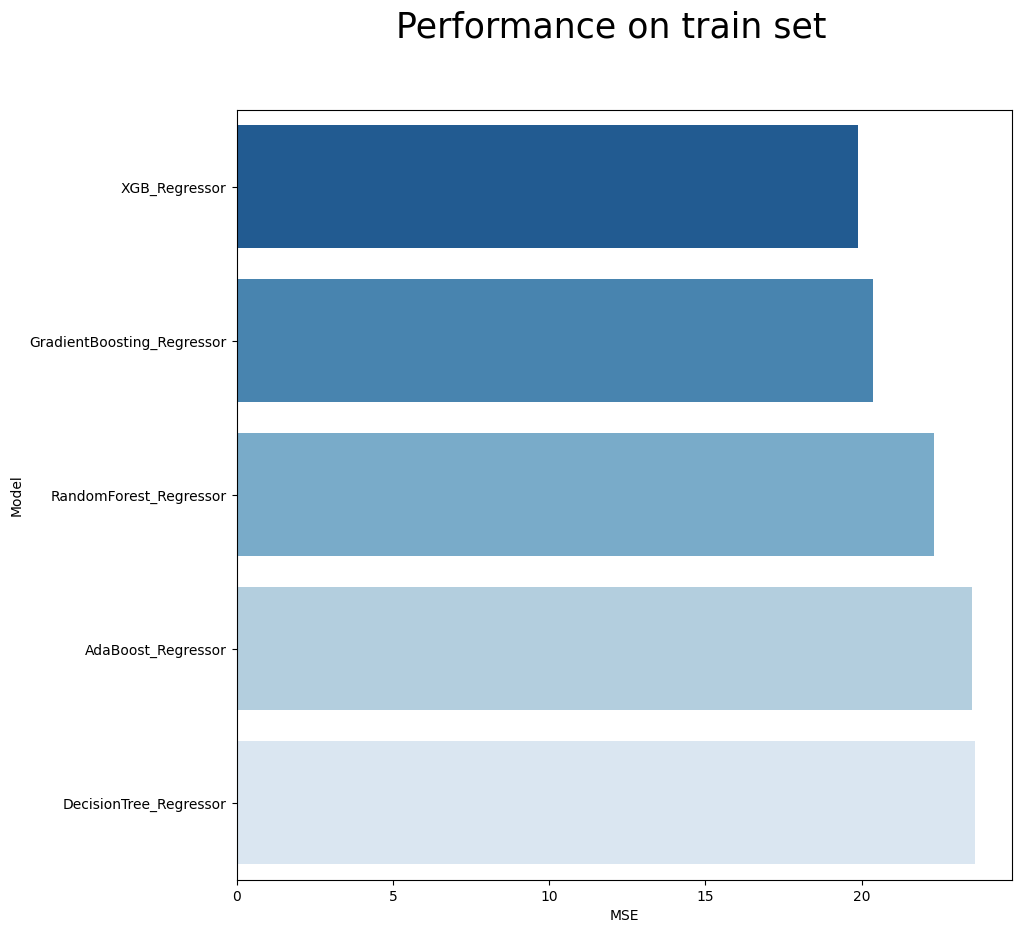

In [55]:
ranking = pd.DataFrame.from_dict(scores, orient='index').reset_index()

ranking.columns = ['Model', 'Setting', 'MSE']
ranking = ranking.sort_values(by='MSE', ascending=True).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 10))
fig.suptitle("Performance on train set", fontsize=25)
sns.barplot(x="MSE", y="Model", data=ranking, ax=ax, palette = 'Blues_r');

Let's see some feature importance

In [56]:
def feature_imp(coef, names):
    imp = coef
    indexes = np.argsort(imp)[-11:]
    indexes = list(indexes)
    
    plt.barh(range(len(indexes)), imp[indexes], align='center')
    plt.yticks(range(len(indexes)), [names[i] for i in indexes])
    plt.show()
    
    return indexes

In [57]:
feature_names = X_train.columns

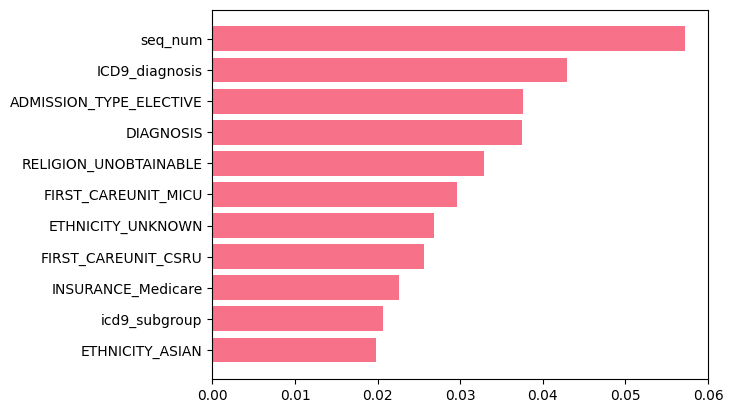

In [60]:
#From the XGBoost regressor
xgb_opt = models[0].fit(X_train, y_train)
feat_indexes_xgb = feature_imp(abs(xgb_opt.feature_importances_), feature_names)

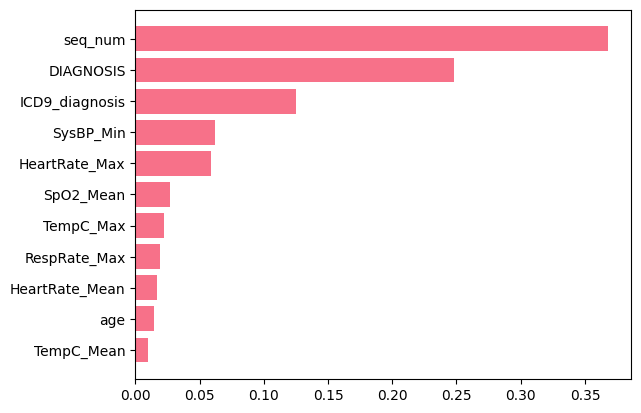

In [61]:
#From the Decision tree regressor
dectree_opt = models[1].fit(X_train, y_train)
feat_indexes_dectree = feature_imp(abs(dectree_opt.feature_importances_), feature_names)

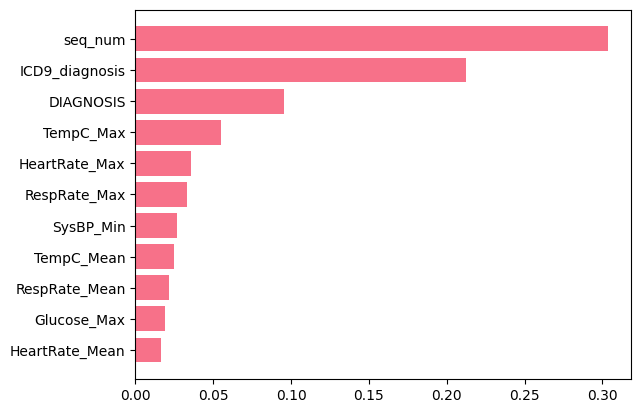

In [62]:
#From the Random Forest regressor
randomforest_opt = models[2].fit(X_train, y_train)
feat_indexes_randomforest = feature_imp(abs(randomforest_opt.feature_importances_), feature_names)

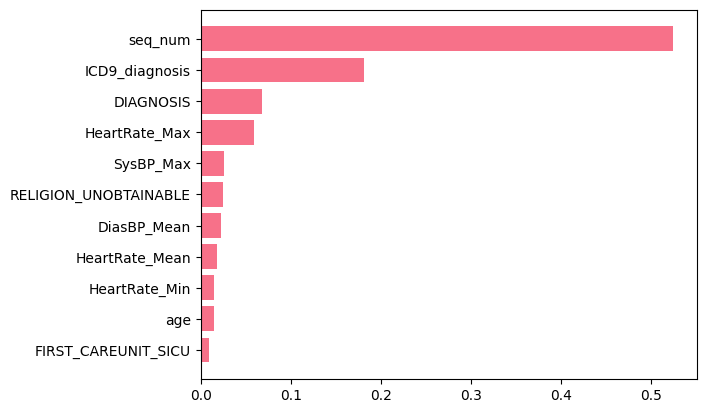

In [63]:
#From AdaBoost
adab_opt = models[3].fit(X_train, y_train)
feat_indexes_adab = feature_imp(abs(adab_opt.feature_importances_), feature_names)

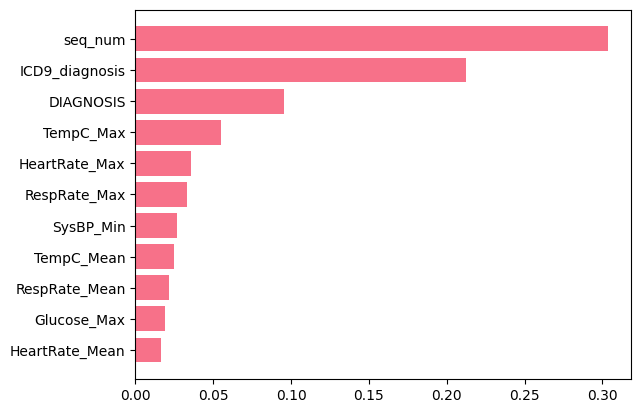

In [64]:
#FRom gradient boost
gb_opt = models[2].fit(X_train, y_train)
feat_indexes_gb = feature_imp(abs(gb_opt.feature_importances_), feature_names)

# 4. Superlearner

In [80]:
def get_models():
    #library of simple learners
    knn = KNeighborsRegressor(n_neighbors=75, weights='distance')
    rf = RandomForestRegressor(max_depth= 50, min_impurity_decrease = 1e-05, min_samples_leaf= 50, n_estimators=750)
    svr = SVR()
    lr = LinearRegression()

    models = {'svr': svr,
              'rf': rf,
              'knn': knn,
              'lr': lr,
              }

    return models

models = get_models()
meta_learner = ExtraTreesRegressor(
    n_estimators=50,
    bootstrap=True,
    max_features=0.7,
    random_state=SEED)

In [81]:
s_l = SuperLearner(
    folds=5,
    random_state=SEED,
    verbose=2,
    backend="multiprocessing",
    n_jobs=-1
)

# Adding base learners and the meta learner
s_l.add(list(models.values()))
s_l.add_meta(meta_learner)

# Train the ensemble
s_l.fit(X_train, y_train)

# Predict the test set
pred_s_l = s_l.predict(X_test)


Fitting 2 layers
Processing layer-1             done | 00:06:46
Processing layer-2             done | 00:00:02
Fit complete                        | 00:06:49

Predicting 2 layers
Processing layer-1             done | 00:00:24
Processing layer-2             done | 00:00:01
Predict complete                    | 00:00:26


In [82]:
# Produce .csv for kaggle testing 
test_predictions_submit = pd.DataFrame({"icustay_id": df_test_copy["icustay_id"], "LOS": pred_s_l})
test_predictions_submit.to_csv("test_predictions_submit_s_l.csv", index = False)

# 5. Model Interpretability(Shap)

In [67]:
!pip install shap

     -------------------------------------- 435.6/435.6 kB 2.3 MB/s eta 0:00:00
     ---------------------------------------- 2.5/2.5 MB 4.7 MB/s eta 0:00:00
     --------------------------------------- 23.2/23.2 MB 16.8 MB/s eta 0:00:00


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


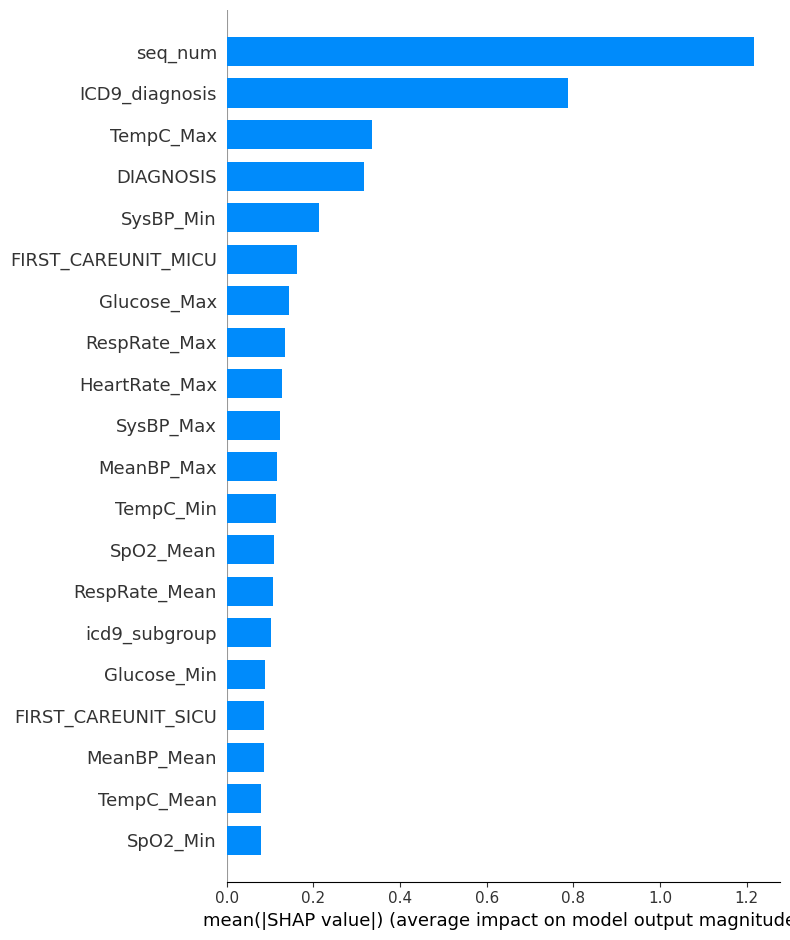

In [71]:
import shap
# Visualizing Shap values

df, target = X_train, y_train
#df, target = X_train, y_train

explainer = shap.TreeExplainer(xgb_opt)
shap_values = explainer.shap_values(df)
shap.initjs()
shap.summary_plot(shap_values, df, plot_type="bar")

In [72]:
# # Visualizing SHAP values for training data as plot

# shap.initjs() ## needed to be added in each cell to get the plot to work
# shap_values = explainer.shap_values(X_train)

# # visualize the training set predictions
# shap.force_plot(explainer.expected_value, shap_values, X_train)

In [73]:
# # Visualizing SHAP values for test data as plot

# shap.initjs() ## needed to be added in each cell to get the plot to work
# shap_values = explainer.shap_values(X_test)

# # visualize the test set predictions
# shap.force_plot(explainer.expected_value, shap_values, X_test)

# 5.1 Model Interpretability(Lime)

In [105]:
!pip install lime

     -------------------------------------- 275.7/275.7 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     --------------------------------------- 23.9/23.9 MB 14.9 MB/s eta 0:00:00
     ---------------------------------------- 3.4/3.4 MB 15.3 MB/s eta 0:00:00
     ------------------------------------- 218.7/218.7 kB 13.0 MB/s eta 0:00:00
  Using cached scipy-1.9.1-cp39-cp39-win_amd64.whl (38.6 MB)
  Using cached networkx-3.0-py3-none-any.whl (2.0 MB)
     ---------------------------------------- 4.2/4.2 MB 11.6 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283846 sha256=94b33427102522627b92c129ae3fe335c57ac2d284bb96d432e3b2e50cac970e
  Stored in directory: c:\users\bakwe\appdata\local\pip\cache\wheels\6e\ad\de\6e1f2abd50acd8aa9a4c6f2a5201cc8700099ce184922e8724
Successfully built lime
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.0
    Uni

In [83]:
import lime
import lime.lime_tabular

In [84]:
explainer = lime.lime_tabular.LimeTabularExplainer(np.array(X_train), 
                                                    feature_names=X_train.columns, 
                                                    verbose = True, mode = 'classification')

In [116]:
#I got stuck here. I really wanted to use LIME also. 
exp = explainer.explain_instance(X_test.iloc[0], svr.)

exp.show_in_notebook(show_table=True)

TypeError: 'numpy.ndarray' object is not callable

# 6. Neural network

In [87]:
X_train.shape

(20885, 66)

In [88]:
! pip install scikeras

In [91]:
!pip install --upgrade tensorflow

In [94]:
!pip3 install --upgrade tensorflow

I don't understand the error below. I ran the code previously and everything was working perfectly, and when I ran it before submitting I got this error.  I'll try to fix it but if i can't I will be glad if you don't penalize.

In [95]:
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
 
# Function to create model, required for KerasClassifier
def build_model(optimizer='adam', init='glorot_uniform', input_shape=(66,)):
    # create model
    model = Sequential([
    Dense(67, activation='relu', input_shape=input_shape, kernel_initializer=init),
    Dense(67, activation='relu'),
    Dense(1),
    ])
    # Compile model
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=tf.keras.metrics.RootMeanSquaredError())
    return model

 
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# Define the model
model = KerasRegressor(build_fn=build_model)

print(model.get_params().keys())


ImportError: TensorFlow is not installed. SciKeras requires TensorFlow >= 2.7.0.

In [ ]:
# grid search epochs, batch size and optimizer
optimizers = ['rmsprop', 'adam']
# optimizers = ['adam']
init = ['normal', 'uniform']
# init = ['normal']
epochs = [3, 5, 10]
batch_size = [32, 1000]

param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batch_size, model__init=init)## init is a argument of the model remember 

grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_train, y_train)
  


Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


523/523 [==============================] - 3s 4ms/step - loss: 23.2223 - root_mean_squared_error: 4.8190
Epoch 2/3
523/523 [==============================] - 2s 4ms/step - loss: 21.3385 - root_mean_squared_error: 4.6194
Epoch 3/3
523/523 [==============================] - 2s 4ms/step - loss: 21.0263 - root_mean_squared_error: 4.5854
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experim

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


523/523 [==============================] - 2s 3ms/step - loss: 21.9731 - root_mean_squared_error: 4.6876
Epoch 2/3
523/523 [==============================] - 3s 5ms/step - loss: 20.2615 - root_mean_squared_error: 4.5013
Epoch 3/3
523/523 [==============================] - 2s 4ms/step - loss: 19.7980 - root_mean_squared_error: 4.4495
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experim

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


523/523 [==============================] - 2s 3ms/step - loss: 23.0672 - root_mean_squared_error: 4.8028
Epoch 2/3
523/523 [==============================] - 2s 4ms/step - loss: 21.5117 - root_mean_squared_error: 4.6381
Epoch 3/3
523/523 [==============================] - 2s 4ms/step - loss: 21.1828 - root_mean_squared_error: 4.6025
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experim

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 3s 4ms/step - loss: 22.8846 - root_mean_squared_error: 4.7838
Epoch 2/3
523/523 [==============================] - 2s 4ms/step - loss: 21.1243 - root_mean_squared_error: 4.5961
Epoch 3/3
523/523 [==============================] - 2s 4ms/step - loss: 20.6219 - r

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 2s 3ms/step - loss: 21.8840 - root_mean_squared_error: 4.6780
Epoch 2/3
523/523 [==============================] - 2s 3ms/step - loss: 20.3405 - root_mean_squared_error: 4.5100
Epoch 3/3
523/523 [==============================] - 2s 3ms/step - loss: 19.9580 - root_mean_squared_error: 4.4674
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experim

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


523/523 [==============================] - 2s 3ms/step - loss: 22.8387 - root_mean_squared_error: 4.7790
Epoch 2/3
523/523 [==============================] - 2s 4ms/step - loss: 21.3205 - root_mean_squared_error: 4.6174
Epoch 3/3
523/523 [==============================] - 2s 4ms/step - loss: 20.9198 - root_mean_squared_error: 4.5738
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experim

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 4s 4ms/step - loss: 21.5640 - root_mean_squared_error: 4.6437
Epoch 2/3
523/523 [==============================] - 2s 3ms/step - loss: 20.1981 - root_mean_squared_error: 4.4942
Epoch 3/3
523/523 [==============================] - 2s 3ms/step - loss: 19.7553 - r

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


523/523 [==============================] - 2s 3ms/step - loss: 23.3200 - root_mean_squared_error: 4.8291
Epoch 2/3
523/523 [==============================] - 2s 4ms/step - loss: 21.6529 - root_mean_squared_error: 4.6533
Epoch 3/3
523/523 [==============================] - 2s 3ms/step - loss: 21.2533 - root_mean_squared_error: 4.6101
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experim

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


523/523 [==============================] - 2s 3ms/step - loss: 22.3315 - root_mean_squared_error: 4.7256
Epoch 2/3
523/523 [==============================] - 2s 3ms/step - loss: 20.9091 - root_mean_squared_error: 4.5726
Epoch 3/3
523/523 [==============================] - 2s 3ms/step - loss: 20.5528 - root_mean_squared_error: 4.5335
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experim

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


523/523 [==============================] - 2s 3ms/step - loss: 22.0337 - root_mean_squared_error: 4.6940
Epoch 2/3
523/523 [==============================] - 2s 3ms/step - loss: 20.1882 - root_mean_squared_error: 4.4931
Epoch 3/3
523/523 [==============================] - 2s 4ms/step - loss: 19.8232 - root_mean_squared_error: 4.4523
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experim

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 2s 3ms/step - loss: 22.9136 - root_mean_squared_error: 4.7868
Epoch 2/3
523/523 [==============================] - 2s 4ms/step - loss: 21.4009 - root_mean_squared_error: 4.6261
Epoch 3/3
523/523 [==============================] - 2s 3ms/step - loss: 21.0274 - r

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 2s 3ms/step - loss: 21.6937 - root_mean_squared_error: 4.6577
Epoch 2/3
523/523 [==============================] - 2s 3ms/step - loss: 20.2758 - root_mean_squared_error: 4.5029
Epoch 3/3
523/523 [==============================] - 2s 3ms/step - loss: 19.8479 - root_mean_s

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


523/523 [==============================] - 2s 3ms/step - loss: 23.1025 - root_mean_squared_error: 4.8065
Epoch 2/3
523/523 [==============================] - 2s 4ms/step - loss: 21.6648 - root_mean_squared_error: 4.6546
Epoch 3/3
523/523 [==============================] - 3s 5ms/step - loss: 21.3084 - root_mean_squared_error: 4.6161
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experim

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 2s 3ms/step - loss: 22.7479 - root_mean_squared_error: 4.7695
Epoch 2/3
523/523 [==============================] - 2s 3ms/step - loss: 21.2001 - root_mean_squared_error: 4.6044
Epoch 3/3
523/523 [==============================] - 2s 3ms/step - loss: 20.7314 - r

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


523/523 [==============================] - 2s 3ms/step - loss: 21.9620 - root_mean_squared_error: 4.6864
Epoch 2/3
523/523 [==============================] - 2s 4ms/step - loss: 20.2214 - root_mean_squared_error: 4.4968
Epoch 3/3
523/523 [==============================] - 2s 3ms/step - loss: 19.8880 - root_mean_squared_error: 4.4596
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experim

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 3s 4ms/step - loss: 22.9150 - root_mean_squared_error: 4.7870
Epoch 2/3
523/523 [==============================] - 4s 7ms/step - loss: 21.3569 - root_mean_squared_error: 4.6214
Epoch 3/3
523/523 [==============================] - 3s 5ms/step - loss: 21.0032 - r

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 3s 5ms/step - loss: 21.8718 - root_mean_squared_error: 4.6767
Epoch 2/3
523/523 [==============================] - 8s 16ms/step - loss: 20.2522 - root_mean_squared_error: 4.5002
Epoch 3/3
523/523 [==============================] - 2s 3ms/step - loss: 19.9347 - 

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 3s 3ms/step - loss: 22.8900 - root_mean_squared_error: 4.7844
Epoch 2/3
523/523 [==============================] - 2s 4ms/step - loss: 21.6964 - root_mean_squared_error: 4.6579
Epoch 3/3
523/523 [==============================] - 3s 5ms/step - loss: 21.3113 - r

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 3s 3ms/step - loss: 22.5534 - root_mean_squared_error: 4.7490
Epoch 2/3
523/523 [==============================] - 2s 3ms/step - loss: 21.0789 - root_mean_squared_error: 4.5912
Epoch 3/3
523/523 [==============================] - 2s 3ms/step - loss: 20.6200 - r

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


523/523 [==============================] - 2s 4ms/step - loss: 22.0793 - root_mean_squared_error: 4.6989
Epoch 2/3
523/523 [==============================] - 2s 3ms/step - loss: 20.4017 - root_mean_squared_error: 4.5168
Epoch 3/3
523/523 [==============================] - 2s 4ms/step - loss: 20.0466 - root_mean_squared_error: 4.4773
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experim

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 3s 3ms/step - loss: 22.8577 - root_mean_squared_error: 4.7810
Epoch 2/5
523/523 [==============================] - 2s 4ms/step - loss: 21.3449 - root_mean_squared_error: 4.6201
Epoch 3/5
523/523 [==============================] - 2s 4ms/step - loss: 20.9426 - root_mean_s

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 3s 4ms/step - loss: 21.4404 - root_mean_squared_error: 4.6304
Epoch 2/5
523/523 [==============================] - 2s 3ms/step - loss: 20.1433 - root_mean_squared_error: 4.4881
Epoch 3/5
523/523 [==============================] - 2s 4ms/step - loss: 19.7726 - root_mean_s

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


523/523 [==============================] - 3s 3ms/step - loss: 23.2742 - root_mean_squared_error: 4.8243
Epoch 2/5
523/523 [==============================] - 2s 3ms/step - loss: 21.5453 - root_mean_squared_error: 4.6417
Epoch 3/5
523/523 [==============================] - 2s 4ms/step - loss: 21.2063 - root_mean_squared_error: 4.6050
Epoch 4/5
523/523 [==============================] - 2s 3ms/step - loss: 20.8961 - root_mean_squared_error: 4.5712
Epoch 5/5
523/523 [==============================] - 2s 4ms/step - loss: 20.5803 - root_mean_squared_error: 4.5366
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on 

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 4s 6ms/step - loss: 22.6938 - root_mean_squared_error: 4.7638
Epoch 2/5
523/523 [==============================] - 2s 4ms/step - loss: 21.0328 - root_mean_squared_error: 4.5862
Epoch 3/5
523/523 [==============================] - 2s 4ms/step - loss: 20.5285 - r

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 3s 3ms/step - loss: 22.1266 - root_mean_squared_error: 4.7039
Epoch 2/5
523/523 [==============================] - 2s 4ms/step - loss: 20.3084 - root_mean_squared_error: 4.5065
Epoch 3/5
523/523 [==============================] - 2s 4ms/step - loss: 19.8218 - r

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


523/523 [==============================] - 2s 3ms/step - loss: 22.7507 - root_mean_squared_error: 4.7698
Epoch 2/5
523/523 [==============================] - 2s 3ms/step - loss: 21.3223 - root_mean_squared_error: 4.6176
Epoch 3/5
523/523 [==============================] - 2s 4ms/step - loss: 21.0313 - root_mean_squared_error: 4.5860
Epoch 4/5
523/523 [==============================] - 2s 4ms/step - loss: 20.6136 - root_mean_squared_error: 4.5402
Epoch 5/5
523/523 [==============================] - 2s 4ms/step - loss: 20.2801 - root_mean_squared_error: 4.5033
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on 

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 2s 4ms/step - loss: 21.7449 - root_mean_squared_error: 4.6631
Epoch 2/5
523/523 [==============================] - 2s 4ms/step - loss: 20.2642 - root_mean_squared_error: 4.5016
Epoch 3/5
523/523 [==============================] - 2s 4ms/step - loss: 19.8331 - root_mean_s

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 3s 4ms/step - loss: 22.8419 - root_mean_squared_error: 4.7793
Epoch 2/5
523/523 [==============================] - 2s 4ms/step - loss: 21.5109 - root_mean_squared_error: 4.6380
Epoch 3/5
523/523 [==============================] - 2s 4ms/step - loss: 21.0834 - r

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 3s 4ms/step - loss: 22.7137 - root_mean_squared_error: 4.7659
Epoch 2/5
523/523 [==============================] - 2s 4ms/step - loss: 20.9794 - root_mean_squared_error: 4.5803
Epoch 3/5
523/523 [==============================] - 2s 3ms/step - loss: 20.4168 - r

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 3s 3ms/step - loss: 21.9365 - root_mean_squared_error: 4.6836
Epoch 2/5
523/523 [==============================] - 2s 3ms/step - loss: 20.2609 - root_mean_squared_error: 4.5012
Epoch 3/5
523/523 [==============================] - 2s 3ms/step - loss: 19.8805 - r

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 3s 3ms/step - loss: 23.0320 - root_mean_squared_error: 4.7992
Epoch 2/5
523/523 [==============================] - 2s 3ms/step - loss: 21.3932 - root_mean_squared_error: 4.6253
Epoch 3/5
523/523 [==============================] - 2s 3ms/step - loss: 20.9921 - r

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 3s 3ms/step - loss: 21.6854 - root_mean_squared_error: 4.6568
Epoch 2/5
523/523 [==============================] - 2s 3ms/step - loss: 20.2342 - root_mean_squared_error: 4.4982
Epoch 3/5
523/523 [==============================] - 2s 3ms/step - loss: 19.8412 - r

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 3s 3ms/step - loss: 23.2851 - root_mean_squared_error: 4.8255
Epoch 2/5
523/523 [==============================] - 2s 3ms/step - loss: 21.6426 - root_mean_squared_error: 4.6522
Epoch 3/5
523/523 [==============================] - 2s 3ms/step - loss: 21.3008 - r

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 2s 3ms/step - loss: 22.4257 - root_mean_squared_error: 4.7356
Epoch 2/5
523/523 [==============================] - 2s 3ms/step - loss: 21.0590 - root_mean_squared_error: 4.5890
Epoch 3/5
523/523 [==============================] - 2s 3ms/step - loss: 20.6834 - r

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 3s 4ms/step - loss: 21.8446 - root_mean_squared_error: 4.6738
Epoch 2/5
523/523 [==============================] - 2s 3ms/step - loss: 20.3238 - root_mean_squared_error: 4.5082
Epoch 3/5
523/523 [==============================] - 2s 4ms/step - loss: 19.9626 - r

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 3s 4ms/step - loss: 22.8689 - root_mean_squared_error: 4.7821
Epoch 2/5
523/523 [==============================] - 2s 3ms/step - loss: 21.3986 - root_mean_squared_error: 4.6259
Epoch 3/5
523/523 [==============================] - 2s 4ms/step - loss: 21.0700 - r

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 3s 4ms/step - loss: 22.1264 - root_mean_squared_error: 4.7039
Epoch 2/5
523/523 [==============================] - 2s 5ms/step - loss: 20.2875 - root_mean_squared_error: 4.5042
Epoch 3/5
523/523 [==============================] - 3s 5ms/step - loss: 19.8967 - r

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 2s 3ms/step - loss: 23.3664 - root_mean_squared_error: 4.8339
Epoch 2/5
523/523 [==============================] - 2s 4ms/step - loss: 21.6680 - root_mean_squared_error: 4.6549
Epoch 3/5
523/523 [==============================] - 2s 4ms/step - loss: 21.3629 - root_mean_s

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 4s 5ms/step - loss: 23.0380 - root_mean_squared_error: 4.7998
Epoch 2/5
523/523 [==============================] - 2s 4ms/step - loss: 21.0512 - root_mean_squared_error: 4.5882
Epoch 3/5
523/523 [==============================] - 2s 3ms/step - loss: 20.6896 - r

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 2s 3ms/step - loss: 21.9804 - root_mean_squared_error: 4.6883
Epoch 2/5
523/523 [==============================] - 2s 4ms/step - loss: 20.1865 - root_mean_squared_error: 4.4929
Epoch 3/5
523/523 [==============================] - 2s 3ms/step - loss: 19.9482 - r

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 2s 3ms/step - loss: 22.7865 - root_mean_squared_error: 4.7735
Epoch 2/10
523/523 [==============================] - 2s 3ms/step - loss: 21.4594 - root_mean_squared_error: 4.6324
Epoch 3/10
523/523 [==============================] - 2s 3ms/step - loss: 20.9080 

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 2s 3ms/step - loss: 21.6145 - root_mean_squared_error: 4.6491
Epoch 2/10
523/523 [==============================] - 1s 3ms/step - loss: 20.1682 - root_mean_squared_error: 4.4909
Epoch 3/10
523/523 [==============================] - 2s 3ms/step - loss: 19.8372 

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 2s 3ms/step - loss: 23.4330 - root_mean_squared_error: 4.8408
Epoch 2/10
523/523 [==============================] - 2s 3ms/step - loss: 21.6094 - root_mean_squared_error: 4.6486
Epoch 3/10
523/523 [==============================] - 2s 3ms/step - loss: 21.2635 

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 2s 3ms/step - loss: 22.4559 - root_mean_squared_error: 4.7388
Epoch 2/10
523/523 [==============================] - 2s 3ms/step - loss: 21.0621 - root_mean_squared_error: 4.5893
Epoch 3/10
523/523 [==============================] - 2s 4ms/step - loss: 20.5415 

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 2s 3ms/step - loss: 21.3648 - root_mean_squared_error: 4.6222
Epoch 2/10
523/523 [==============================] - 2s 3ms/step - loss: 20.1815 - root_mean_squared_error: 4.4924
Epoch 3/10
523/523 [==============================] - 2s 3ms/step - loss: 19.8588 

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 2s 3ms/step - loss: 22.9179 - root_mean_squared_error: 4.7873
Epoch 2/10
523/523 [==============================] - 2s 3ms/step - loss: 21.3361 - root_mean_squared_error: 4.6191
Epoch 3/10
523/523 [==============================] - 2s 3ms/step - loss: 20.9833 

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 2s 3ms/step - loss: 21.4535 - root_mean_squared_error: 4.6318
Epoch 2/10
523/523 [==============================] - 2s 3ms/step - loss: 20.1848 - root_mean_squared_error: 4.4928
Epoch 3/10
523/523 [==============================] - 2s 3ms/step - loss: 19.7807 

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 3s 3ms/step - loss: 22.9700 - root_mean_squared_error: 4.7927
Epoch 2/10
523/523 [==============================] - 2s 3ms/step - loss: 21.5493 - root_mean_squared_error: 4.6421
Epoch 3/10
523/523 [==============================] - 2s 3ms/step - loss: 21.2376 

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 3s 4ms/step - loss: 22.6610 - root_mean_squared_error: 4.7604
Epoch 2/10
523/523 [==============================] - 2s 3ms/step - loss: 21.0237 - root_mean_squared_error: 4.5852
Epoch 3/10
523/523 [==============================] - 2s 3ms/step - loss: 20.6991 

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 2s 3ms/step - loss: 21.6195 - root_mean_squared_error: 4.6497
Epoch 2/10
523/523 [==============================] - 2s 3ms/step - loss: 20.1723 - root_mean_squared_error: 4.4914
Epoch 3/10
523/523 [==============================] - 2s 3ms/step - loss: 19.8070 - root_mean

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 3s 3ms/step - loss: 23.1937 - root_mean_squared_error: 4.8160
Epoch 2/10
523/523 [==============================] - 2s 3ms/step - loss: 21.3362 - root_mean_squared_error: 4.6191
Epoch 3/10
523/523 [==============================] - 2s 3ms/step - loss: 21.0454 

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 3s 3ms/step - loss: 21.9046 - root_mean_squared_error: 4.6802
Epoch 2/10
523/523 [==============================] - 2s 3ms/step - loss: 20.3036 - root_mean_squared_error: 4.5059
Epoch 3/10
523/523 [==============================] - 2s 3ms/step - loss: 19.9577 

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 3s 3ms/step - loss: 23.3912 - root_mean_squared_error: 4.8364
Epoch 2/10
523/523 [==============================] - 2s 3ms/step - loss: 21.6429 - root_mean_squared_error: 4.6522
Epoch 3/10
523/523 [==============================] - 2s 4ms/step - loss: 21.3238 

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 3s 4ms/step - loss: 22.5588 - root_mean_squared_error: 4.7496
Epoch 2/10
523/523 [==============================] - 2s 4ms/step - loss: 21.1109 - root_mean_squared_error: 4.5947
Epoch 3/10
523/523 [==============================] - 2s 5ms/step - loss: 20.6725 

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 2s 3ms/step - loss: 21.7661 - root_mean_squared_error: 4.6654
Epoch 2/10
523/523 [==============================] - 2s 3ms/step - loss: 20.1668 - root_mean_squared_error: 4.4907
Epoch 3/10
523/523 [==============================] - 2s 4ms/step - loss: 19.9799 

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


523/523 [==============================] - 2s 3ms/step - loss: 23.3459 - root_mean_squared_error: 4.8318
Epoch 2/10
523/523 [==============================] - 2s 3ms/step - loss: 21.4135 - root_mean_squared_error: 4.6275
Epoch 3/10
523/523 [==============================] - 2s 4ms/step - loss: 20.9816 - root_mean_squared_error: 4.5806
Epoch 4/10
523/523 [==============================] - 3s 5ms/step - loss: 20.6993 - root_mean_squared_error: 4.5496
Epoch 5/10
523/523 [==============================] - 2s 4ms/step - loss: 20.4392 - root_mean_squared_error: 4.5210
Epoch 6/10
523/523 [==============================] - 2s 4ms/step - loss: 20.0828 - root_mean_squared_error: 4.4814
Epoch 7/10
523/523 [==============================] - 2s 4ms/step - loss: 19.7668 - root_mean_squared_error: 4.4460
Epoch 8/10
523/523 [==============================] - 2s 3ms/step - loss: 19.3616 - root_mean_squared_error: 4.4002
Epoch 9/10
523/523 [==============================] - 2s 4ms/step - loss: 19.0918 -

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 3s 4ms/step - loss: 21.5996 - root_mean_squared_error: 4.6475
Epoch 2/10
523/523 [==============================] - 2s 4ms/step - loss: 20.2547 - root_mean_squared_error: 4.5005
Epoch 3/10
523/523 [==============================] - 2s 4ms/step - loss: 19.8641 - root_mean

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 3s 4ms/step - loss: 23.1171 - root_mean_squared_error: 4.8080
Epoch 2/10
523/523 [==============================] - 2s 4ms/step - loss: 21.5042 - root_mean_squared_error: 4.6373
Epoch 3/10
523/523 [==============================] - 3s 5ms/step - loss: 21.2845 

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 3s 4ms/step - loss: 22.4151 - root_mean_squared_error: 4.7345
Epoch 2/10
523/523 [==============================] - 2s 3ms/step - loss: 21.0448 - root_mean_squared_error: 4.5875
Epoch 3/10
523/523 [==============================] - 2s 4ms/step - loss: 20.6870 

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
523/523 [==============================] - 6s 8ms/step - loss: 21.5872 - root_mean_squared_error: 4.6462
Epoch 2/10
523/523 [==============================] - 3s 5ms/step - loss: 20.2904 - root_mean_squared_error: 4.5045
Epoch 3/10
523/523 [==============================] - 2s 5ms/step - loss: 20.0014 

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 2s 5ms/step - loss: 32.5297 - root_mean_squared_error: 5.7035
Epoch 2/3
17/17 [==============================] - 0s 5ms/step - loss: 25.2017 - root_mean_squared_error: 5.0201
Epoch 3/3
17/17 [==============================] - 0s 5ms/step - loss: 23.8613 - root_me

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 5ms/step - loss: 32.7920 - root_mean_squared_error: 5.7264
Epoch 2/3
17/17 [==============================] - 0s 5ms/step - loss: 24.3814 - root_mean_squared_error: 4.9377
Epoch 3/3
17/17 [==============================] - 0s 6ms/step - loss: 22.8938 - root_me

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 6ms/step - loss: 37.9337 - root_mean_squared_error: 6.1590
Epoch 2/3
17/17 [==============================] - 0s 6ms/step - loss: 26.7778 - root_mean_squared_error: 5.1747
Epoch 3/3
17/17 [==============================] - 0s 6ms/step - loss: 24.4833 - root_me

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 5ms/step - loss: 33.3809 - root_mean_squared_error: 5.7776
Epoch 2/3
17/17 [==============================] - 0s 5ms/step - loss: 24.9201 - root_mean_squared_error: 4.9920
Epoch 3/3
17/17 [==============================] - 0s 17ms/step - loss: 23.6760 - root_m

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 7ms/step - loss: 32.3882 - root_mean_squared_error: 5.6911
Epoch 2/3
17/17 [==============================] - 0s 5ms/step - loss: 24.1685 - root_mean_squared_error: 4.9162
Epoch 3/3
17/17 [==============================] - 0s 12ms/step - loss: 22.8723 - root_m

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 3ms/step - loss: 34.8619 - root_mean_squared_error: 5.9044
Epoch 2/3
17/17 [==============================] - 0s 5ms/step - loss: 25.6761 - root_mean_squared_error: 5.0672
Epoch 3/3
17/17 [==============================] - 0s 4ms/step - loss: 23.9427 - root_me

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 7ms/step - loss: 31.6794 - root_mean_squared_error: 5.6284
Epoch 2/3
17/17 [==============================] - 0s 4ms/step - loss: 23.9636 - root_mean_squared_error: 4.8953
Epoch 3/3
17/17 [==============================] - 0s 4ms/step - loss: 22.6159 - root_me

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 6ms/step - loss: 35.3734 - root_mean_squared_error: 5.9476
Epoch 2/3
17/17 [==============================] - 0s 4ms/step - loss: 25.6959 - root_mean_squared_error: 5.0691
Epoch 3/3
17/17 [==============================] - 0s 4ms/step - loss: 24.1805 - root_me

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 3ms/step - loss: 36.6823 - root_mean_squared_error: 6.0566
Epoch 2/3
17/17 [==============================] - 0s 5ms/step - loss: 26.4209 - root_mean_squared_error: 5.1401
Epoch 3/3
17/17 [==============================] - 0s 4ms/step - loss: 24.0004 - root_me

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 4ms/step - loss: 33.1340 - root_mean_squared_error: 5.7562
Epoch 2/3
17/17 [==============================] - 0s 6ms/step - loss: 24.6083 - root_mean_squared_error: 4.9607
Epoch 3/3
17/17 [==============================] - 0s 7ms/step - loss: 22.9953 - root_me

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 4ms/step - loss: 35.5605 - root_mean_squared_error: 5.9633
Epoch 2/3
17/17 [==============================] - 0s 6ms/step - loss: 25.9247 - root_mean_squared_error: 5.0916
Epoch 3/3
17/17 [==============================] - 0s 5ms/step - loss: 24.2932 - root_me

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 5ms/step - loss: 34.8040 - root_mean_squared_error: 5.8995
Epoch 2/3
17/17 [==============================] - 0s 5ms/step - loss: 24.6137 - root_mean_squared_error: 4.9612
Epoch 3/3
17/17 [==============================] - 0s 5ms/step - loss: 22.7404 - root_me

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 7ms/step - loss: 34.5842 - root_mean_squared_error: 5.8808
Epoch 2/3
17/17 [==============================] - 0s 4ms/step - loss: 25.3447 - root_mean_squared_error: 5.0343
Epoch 3/3
17/17 [==============================] - 0s 14ms/step - loss: 24.0434 - root_m

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 4ms/step - loss: 35.2690 - root_mean_squared_error: 5.9388
Epoch 2/3
17/17 [==============================] - 0s 26ms/step - loss: 25.1468 - root_mean_squared_error: 5.0147
Epoch 3/3
17/17 [==============================] - 1s 48ms/step - loss: 23.6261 - root_

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 8ms/step - loss: 33.4449 - root_mean_squared_error: 5.7832
Epoch 2/3
17/17 [==============================] - 0s 18ms/step - loss: 24.1632 - root_mean_squared_error: 4.9156
Epoch 3/3
17/17 [==============================] - 0s 5ms/step - loss: 22.7409 - root_m

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 5ms/step - loss: 36.7777 - root_mean_squared_error: 6.0645
Epoch 2/3
17/17 [==============================] - 0s 6ms/step - loss: 26.5797 - root_mean_squared_error: 5.1556
Epoch 3/3
17/17 [==============================] - 0s 6ms/step - loss: 24.3319 - root_me

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 4ms/step - loss: 35.2414 - root_mean_squared_error: 5.9364
Epoch 2/3
17/17 [==============================] - 0s 4ms/step - loss: 24.9351 - root_mean_squared_error: 4.9935
Epoch 3/3
17/17 [==============================] - 0s 4ms/step - loss: 22.9476 - root_me

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 3ms/step - loss: 32.5955 - root_mean_squared_error: 5.7092
Epoch 2/3
17/17 [==============================] - 0s 4ms/step - loss: 24.8616 - root_mean_squared_error: 4.9861
Epoch 3/3
17/17 [==============================] - 0s 4ms/step - loss: 23.6585 - root_me

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 6ms/step - loss: 34.5064 - root_mean_squared_error: 5.8742
Epoch 2/3
17/17 [==============================] - 0s 4ms/step - loss: 24.7995 - root_mean_squared_error: 4.9799
Epoch 3/3
17/17 [==============================] - 0s 4ms/step - loss: 23.4022 - root_me

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 3ms/step - loss: 35.1416 - root_mean_squared_error: 5.9280
Epoch 2/3
17/17 [==============================] - 0s 3ms/step - loss: 24.8837 - root_mean_squared_error: 4.9884
Epoch 3/3
17/17 [==============================] - 0s 3ms/step - loss: 22.8705 - root_mean_squared

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 3ms/step - loss: 33.3794 - root_mean_squared_error: 5.7775
Epoch 2/5
17/17 [==============================] - 0s 3ms/step - loss: 25.1624 - root_mean_squared_error: 5.0162
Epoch 3/5
17/17 [==============================] - 0s 4ms/step - loss: 23.8773 - root_mean_squared

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 8ms/step - loss: 31.9246 - root_mean_squared_error: 5.6502
Epoch 2/5
17/17 [==============================] - 0s 19ms/step - loss: 24.0123 - root_mean_squared_error: 4.9002
Epoch 3/5
17/17 [==============================] - 0s 11ms/step - loss: 22.8166 - root_

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 3ms/step - loss: 33.5512 - root_mean_squared_error: 5.7923
Epoch 2/5
17/17 [==============================] - 0s 4ms/step - loss: 25.2817 - root_mean_squared_error: 5.0281
Epoch 3/5
17/17 [==============================] - 0s 4ms/step - loss: 23.8785 - root_me

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 3ms/step - loss: 32.4454 - root_mean_squared_error: 5.6961
Epoch 2/5
17/17 [==============================] - 0s 7ms/step - loss: 24.8081 - root_mean_squared_error: 4.9808
Epoch 3/5
17/17 [==============================] - 0s 4ms/step - loss: 23.4853 - root_me

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 3ms/step - loss: 31.4578 - root_mean_squared_error: 5.6087
Epoch 2/5
17/17 [==============================] - 0s 3ms/step - loss: 23.9985 - root_mean_squared_error: 4.8988
Epoch 3/5
17/17 [==============================] - 0s 3ms/step - loss: 22.8417 - root_me

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 5ms/step - loss: 37.5797 - root_mean_squared_error: 6.1302
Epoch 2/5
17/17 [==============================] - 0s 5ms/step - loss: 26.8656 - root_mean_squared_error: 5.1832
Epoch 3/5
17/17 [==============================] - 0s 5ms/step - loss: 24.4302 - root_me

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 4ms/step - loss: 33.2554 - root_mean_squared_error: 5.7667
Epoch 2/5
17/17 [==============================] - 0s 3ms/step - loss: 24.3385 - root_mean_squared_error: 4.9334
Epoch 3/5
17/17 [==============================] - 0s 4ms/step - loss: 22.8196 - root_me

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 4ms/step - loss: 34.6024 - root_mean_squared_error: 5.8824
Epoch 2/5
17/17 [==============================] - 0s 4ms/step - loss: 25.2671 - root_mean_squared_error: 5.0266
Epoch 3/5
17/17 [==============================] - 0s 4ms/step - loss: 23.7762 - root_me

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 3ms/step - loss: 35.7215 - root_mean_squared_error: 5.9767
Epoch 2/5
17/17 [==============================] - 0s 3ms/step - loss: 25.3813 - root_mean_squared_error: 5.0380
Epoch 3/5
17/17 [==============================] - 0s 4ms/step - loss: 23.6106 - root_me

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 5ms/step - loss: 31.6210 - root_mean_squared_error: 5.6233
Epoch 2/5
17/17 [==============================] - 0s 6ms/step - loss: 23.8329 - root_mean_squared_error: 4.8819
Epoch 3/5
17/17 [==============================] - 0s 6ms/step - loss: 22.4964 - root_mean_squared

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 8ms/step - loss: 35.1227 - root_mean_squared_error: 5.9264
Epoch 2/5
17/17 [==============================] - 0s 6ms/step - loss: 25.2913 - root_mean_squared_error: 5.0291
Epoch 3/5
17/17 [==============================] - 0s 5ms/step - loss: 23.8288 - root_me

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 16ms/step - loss: 33.2304 - root_mean_squared_error: 5.7646
Epoch 2/5
17/17 [==============================] - 0s 9ms/step - loss: 23.9836 - root_mean_squared_error: 4.8973
Epoch 3/5
17/17 [==============================] - 0s 7ms/step - loss: 22.4272 - root_m

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 4ms/step - loss: 38.5238 - root_mean_squared_error: 6.2068
Epoch 2/5
17/17 [==============================] - 0s 4ms/step - loss: 27.6433 - root_mean_squared_error: 5.2577
Epoch 3/5
17/17 [==============================] - 0s 4ms/step - loss: 24.5571 - root_me

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 3ms/step - loss: 36.4815 - root_mean_squared_error: 6.0400
Epoch 2/5
17/17 [==============================] - 0s 4ms/step - loss: 26.2519 - root_mean_squared_error: 5.1237
Epoch 3/5
17/17 [==============================] - 0s 4ms/step - loss: 23.9490 - root_me

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 3ms/step - loss: 35.6240 - root_mean_squared_error: 5.9686
Epoch 2/5
17/17 [==============================] - 0s 3ms/step - loss: 25.2411 - root_mean_squared_error: 5.0241
Epoch 3/5
17/17 [==============================] - 0s 6ms/step - loss: 23.1793 - root_me

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 3ms/step - loss: 34.3610 - root_mean_squared_error: 5.8618
Epoch 2/5
17/17 [==============================] - 0s 3ms/step - loss: 25.2340 - root_mean_squared_error: 5.0233
Epoch 3/5
17/17 [==============================] - 0s 4ms/step - loss: 23.9284 - root_me

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 3ms/step - loss: 33.1370 - root_mean_squared_error: 5.7565
Epoch 2/5
17/17 [==============================] - 0s 3ms/step - loss: 24.0127 - root_mean_squared_error: 4.9003
Epoch 3/5
17/17 [==============================] - 0s 4ms/step - loss: 22.6341 - root_me

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 3ms/step - loss: 36.0384 - root_mean_squared_error: 6.0032
Epoch 2/5
17/17 [==============================] - 0s 4ms/step - loss: 26.0056 - root_mean_squared_error: 5.0996
Epoch 3/5
17/17 [==============================] - 0s 4ms/step - loss: 24.1180 - root_me

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 3ms/step - loss: 34.6731 - root_mean_squared_error: 5.8884
Epoch 2/5
17/17 [==============================] - 0s 3ms/step - loss: 25.2832 - root_mean_squared_error: 5.0282
Epoch 3/5
17/17 [==============================] - 0s 4ms/step - loss: 23.7881 - root_mean_squared

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 3ms/step - loss: 33.0730 - root_mean_squared_error: 5.7509
Epoch 2/5
17/17 [==============================] - 0s 3ms/step - loss: 23.8414 - root_mean_squared_error: 4.8828
Epoch 3/5
17/17 [==============================] - 0s 3ms/step - loss: 22.6553 - root_me

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 3ms/step - loss: 34.9823 - root_mean_squared_error: 5.9146
Epoch 2/10
17/17 [==============================] - 0s 3ms/step - loss: 25.6811 - root_mean_squared_error: 5.0677
Epoch 3/10
17/17 [==============================] - 0s 4ms/step - loss: 24.1973 - root

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 4ms/step - loss: 35.3379 - root_mean_squared_error: 5.9446
Epoch 2/10
17/17 [==============================] - 0s 4ms/step - loss: 25.2744 - root_mean_squared_error: 5.0274
Epoch 3/10
17/17 [==============================] - 0s 4ms/step - loss: 23.2519 - root

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 3ms/step - loss: 34.7320 - root_mean_squared_error: 5.8934
Epoch 2/10
17/17 [==============================] - 0s 4ms/step - loss: 25.2193 - root_mean_squared_error: 5.0219
Epoch 3/10
17/17 [==============================] - 0s 4ms/step - loss: 23.9648 - root

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 3ms/step - loss: 32.6919 - root_mean_squared_error: 5.7177
Epoch 2/10
17/17 [==============================] - 0s 4ms/step - loss: 24.8594 - root_mean_squared_error: 4.9859
Epoch 3/10
17/17 [==============================] - 0s 4ms/step - loss: 23.6226 - root

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 3ms/step - loss: 29.5433 - root_mean_squared_error: 5.4354
Epoch 2/10
17/17 [==============================] - 0s 3ms/step - loss: 23.5639 - root_mean_squared_error: 4.8543
Epoch 3/10
17/17 [==============================] - 0s 4ms/step - loss: 22.3689 - root

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 3ms/step - loss: 35.8335 - root_mean_squared_error: 5.9861
Epoch 2/10
17/17 [==============================] - 0s 3ms/step - loss: 25.7721 - root_mean_squared_error: 5.0766
Epoch 3/10
17/17 [==============================] - 0s 3ms/step - loss: 24.1580 - root

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 3ms/step - loss: 30.9179 - root_mean_squared_error: 5.5604
Epoch 2/10
17/17 [==============================] - 0s 4ms/step - loss: 23.8487 - root_mean_squared_error: 4.8835
Epoch 3/10
17/17 [==============================] - 0s 4ms/step - loss: 22.7077 - root

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 9ms/step - loss: 37.4798 - root_mean_squared_error: 6.1221
Epoch 2/10
17/17 [==============================] - 0s 8ms/step - loss: 26.6752 - root_mean_squared_error: 5.1648
Epoch 3/10
17/17 [==============================] - 0s 6ms/step - loss: 24.5455 - root

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 5ms/step - loss: 33.2710 - root_mean_squared_error: 5.7681
Epoch 2/10
17/17 [==============================] - 0s 5ms/step - loss: 24.9764 - root_mean_squared_error: 4.9976
Epoch 3/10
17/17 [==============================] - 0s 4ms/step - loss: 23.6330 - root

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 10ms/step - loss: 33.5263 - root_mean_squared_error: 5.7902
Epoch 2/10
17/17 [==============================] - 0s 5ms/step - loss: 24.7609 - root_mean_squared_error: 4.9760
Epoch 3/10
17/17 [==============================] - 0s 4ms/step - loss: 23.3270 - roo

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 14ms/step - loss: 36.3163 - root_mean_squared_error: 6.0263
Epoch 2/10
17/17 [==============================] - 0s 25ms/step - loss: 26.0012 - root_mean_squared_error: 5.0991
Epoch 3/10
17/17 [==============================] - 0s 19ms/step - loss: 24.0906 - r

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 8ms/step - loss: 34.7890 - root_mean_squared_error: 5.8982
Epoch 2/10
17/17 [==============================] - 0s 9ms/step - loss: 24.5192 - root_mean_squared_error: 4.9517
Epoch 3/10
17/17 [==============================] - 0s 13ms/step - loss: 22.8153 - roo

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 10ms/step - loss: 37.8895 - root_mean_squared_error: 6.1554
Epoch 2/10
17/17 [==============================] - 0s 7ms/step - loss: 27.6455 - root_mean_squared_error: 5.2579
Epoch 3/10
17/17 [==============================] - 0s 14ms/step - loss: 24.3219 - ro

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 9ms/step - loss: 35.4918 - root_mean_squared_error: 5.9575
Epoch 2/10
17/17 [==============================] - 0s 13ms/step - loss: 25.6194 - root_mean_squared_error: 5.0616
Epoch 3/10
17/17 [==============================] - 0s 22ms/step - loss: 23.7267 - ro

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 13ms/step - loss: 33.0582 - root_mean_squared_error: 5.7496
Epoch 2/10
17/17 [==============================] - 0s 11ms/step - loss: 23.9076 - root_mean_squared_error: 4.8895
Epoch 3/10
17/17 [==============================] - 0s 10ms/step - loss: 22.4116 - r

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 4ms/step - loss: 36.7386 - root_mean_squared_error: 6.0612
Epoch 2/10
17/17 [==============================] - 0s 7ms/step - loss: 26.5036 - root_mean_squared_error: 5.1482
Epoch 3/10
17/17 [==============================] - 0s 12ms/step - loss: 24.3322 - roo

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 4ms/step - loss: 34.5391 - root_mean_squared_error: 5.8770
Epoch 2/10
17/17 [==============================] - 0s 7ms/step - loss: 24.8791 - root_mean_squared_error: 4.9879
Epoch 3/10
17/17 [==============================] - 0s 9ms/step - loss: 22.8434 - root

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 7ms/step - loss: 36.4070 - root_mean_squared_error: 6.0338
Epoch 2/10
17/17 [==============================] - 0s 17ms/step - loss: 26.0090 - root_mean_squared_error: 5.0999
Epoch 3/10
17/17 [==============================] - 0s 13ms/step - loss: 24.2029 - ro

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 11ms/step - loss: 35.2383 - root_mean_squared_error: 5.9362
Epoch 2/10
17/17 [==============================] - 0s 28ms/step - loss: 25.2372 - root_mean_squared_error: 5.0237
Epoch 3/10
17/17 [==============================] - 0s 16ms/step - loss: 23.5410 - r

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
17/17 [==============================] - 1s 5ms/step - loss: 33.7009 - root_mean_squared_error: 5.8052
Epoch 2/10
17/17 [==============================] - 0s 8ms/step - loss: 24.3651 - root_mean_squared_error: 4.9361
Epoch 3/10
17/17 [==============================] - 0s 6ms/step - loss: 22.7420 - root

c:\Users\bakwe\anaconda3\envs\tf\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
653/653 [==============================] - 3s 4ms/step - loss: 22.2889 - root_mean_squared_error: 4.7211
Epoch 2/5
653/653 [==============================] - 3s 5ms/step - loss: 20.8362 - root_mean_squared_error: 4.5647
Epoch 3/5
653/653 [==============================] - 3s 4ms/step - loss: 20.4492 - r

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.232836 using {'batch_size': 32, 'epochs': 5, 'model__init': 'uniform', 'optimizer': 'rmsprop'}
0.223253 (0.017304) with: {'batch_size': 32, 'epochs': 3, 'model__init': 'normal', 'optimizer': 'rmsprop'}
0.221356 (0.017783) with: {'batch_size': 32, 'epochs': 3, 'model__init': 'normal', 'optimizer': 'adam'}
0.224359 (0.019697) with: {'batch_size': 32, 'epochs': 3, 'model__init': 'uniform', 'optimizer': 'rmsprop'}
0.222646 (0.019070) with: {'batch_size': 32, 'epochs': 3, 'model__init': 'uniform', 'optimizer': 'adam'}
0.229728 (0.024512) with: {'batch_size': 32, 'epochs': 5, 'model__init': 'normal', 'optimizer': 'rmsprop'}
0.213728 (0.032119) with: {'batch_size': 32, 'epochs': 5, 'model__init': 'normal', 'optimizer': 'adam'}
0.232836 (0.022859) with: {'batch_size': 32, 'epochs': 5, 'model__init': 'uniform', 'optimizer': 'rmsprop'}
0.228728 (0.017886) with: {'batch_size': 32, 'epochs': 5, 'model__init': 'uniform', 'optimizer': 'adam'}
0.210929 (0.033149) with: {'batch_size': 32, 'epo

In [ ]:
y_hat_test = grid.predict(X_test)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
164/164 [==============================] - 1s 5ms/step


In [ ]:
# Produce .csv for kaggle testing 
test_predictions_submit = pd.DataFrame({"icustay_id": df_test["icustay_id"], "LOS": y_hat_test})
test_predictions_submit.to_csv("test_predictions_submit_nn.csv", index = False)

# 7. Conclusion

The MIMIC database offered surprisingly good depth and detail related to medical admissions which enabled me to create a hospital length-of-stay prediction model that considered a lot of interesting input features. If I had time I would look more into other variables like the <i> Heart_rate, Blood_pressure, Glucose etc..</i>. By far, the most challenging aspect of this project was the feature engineering of the ICD-9 diagnoses into a more practical and interpretable form of supercategories. However, therein also lies the most obvious area for future improvement. In other iterations of the project, I used hospital code gotten from https://en.wikipedia.org/wiki/List_of_ICD-9_codes , I was able to create a list of diagnosis category, and when i checked which diagnosis had the highest LOS it was "prenatal", which will be an obvious answer. Unfortunately that variation yielded a bad result. I will keep trying it in the future for my Github.  </br>
Thank you for such an interesting challenge.